In [1]:
# Import
from model import ResDenseNet
import torch
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from datetime import datetime
import os
import pandas as pd
from tqdm import tqdm


In [2]:
# Parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
local_storage_dir = "/home/md775/LocalStorage/MLProjects/CY/" # Change this to your storage directory
dataset_dir = local_storage_dir + "Datasets/GKZ/"
checkpoint_dir = local_storage_dir + "Checkpoints/"
log_dir = local_storage_dir + "Logs/"
train_features_path = dataset_dir + "train_features.csv"
train_labels_path = dataset_dir + "train_labels.csv"
test_features_path = dataset_dir + "test_features.csv"
test_labels_path = dataset_dir + "test_labels.csv"

# Create directories
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

batch_size = 2**10
validation_split = 0.2 # 20% of the training data is used for validation

In [3]:
# Load Dataset
class GKZDataset(Dataset):
    def __init__(self, features_path, labels_path):
        self.features = pd.read_csv(features_path, header=None).astype('float32')
        self.labels = pd.read_csv(labels_path, header=None).astype('float32')
        assert len(self.features) == len(self.labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features.iloc[idx].values), torch.tensor(self.labels.iloc[idx].values)
    
# Create Dataset
train_dataset = GKZDataset(train_features_path, train_labels_path)
validation_size = int(validation_split * len(train_dataset))
train_size = len(train_dataset) - validation_size
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, validation_size])
test_dataset = GKZDataset(test_features_path, test_labels_path)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=16)

# Set input size
input_size = len(train_dataset[0][0])

In [4]:
# Create Model
model = ResDenseNet(input_size=input_size, width=1024, depth=8, dropout=0.2).to(device)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

# Create Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995, last_epoch=-1, verbose=False)

# Create Loss Function
def loss_fn(true,pred):
    return F.mse_loss(true, pred) + F.l1_loss(true, pred)


Number of parameters:  8433673


In [5]:
# Training
epochs = 400
checkpoint_interval = 5
model.train()
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(log_dir=log_dir+timestamp)

num_batches = len(train_loader)
for epoch in range(1, epochs+1):
    epoch_loss = 0
    min_loss = 100000
    with tqdm(train_loader, total=num_batches) as pbar:
        for b,batch in enumerate(pbar):
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            predictions = model(features)
            loss = loss_fn(labels, predictions)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix({"Epoch:": epoch,
                                       "LR:":optimizer.param_groups[0]['lr'],
                                         "Loss:": epoch_loss/(b+1)})
    epoch_loss = epoch_loss/num_batches
    with torch.no_grad():
        model.eval()
        validation_loss = 0
        for b,batch in enumerate(validation_loader):
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)
            predictions = model(features)
            loss = loss_fn(labels, predictions)
            validation_loss += loss.item()
        validation_loss = validation_loss/len(validation_loader)
        model.train()
    if lr_scheduler is not None:
        lr_scheduler.step()
    if checkpoint_dir is not None:
        checkpoint_dict = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler': lr_scheduler.state_dict(),
            'loss': loss
        }
        if validation_loss < min_loss:
            min_loss = validation_loss
            torch.save(checkpoint_dict, os.path.join(checkpoint_dir,
                                                        "model_min_loss.pt"))
            
    writer.add_scalars("Loss", {"Training Loss": epoch_loss, "Validation Loss": validation_loss}, epoch)
    print("Epoch: {} Training Loss: {} Validation Loss: {}".format(epoch, epoch_loss, validation_loss))
    print("LR: {}".format(optimizer.param_groups[0]['lr']))
writer.close()

100%|██████████| 1205/1205 [00:09<00:00, 122.21it/s, Epoch:=1, LR:=0.001, Loss:=0.657]


Epoch: 1 Training Loss: 0.6570340825314344 Validation Loss: 0.1634888170373361
LR: 0.000995


100%|██████████| 1205/1205 [00:08<00:00, 140.65it/s, Epoch:=2, LR:=0.000995, Loss:=0.148]


Epoch: 2 Training Loss: 0.1478135003217523 Validation Loss: 0.13014456543405326
LR: 0.000990025


100%|██████████| 1205/1205 [00:08<00:00, 139.51it/s, Epoch:=3, LR:=0.00099, Loss:=0.125]


Epoch: 3 Training Loss: 0.1248567244323952 Validation Loss: 0.12497884901055437
LR: 0.000985074875


100%|██████████| 1205/1205 [00:08<00:00, 144.19it/s, Epoch:=4, LR:=0.000985, Loss:=0.113]


Epoch: 4 Training Loss: 0.11340563036346832 Validation Loss: 0.10636508642442968
LR: 0.000980149500625


100%|██████████| 1205/1205 [00:08<00:00, 146.53it/s, Epoch:=5, LR:=0.00098, Loss:=0.105]


Epoch: 5 Training Loss: 0.10545335996324096 Validation Loss: 0.09601241557408642
LR: 0.000975248753121875


100%|██████████| 1205/1205 [00:08<00:00, 144.28it/s, Epoch:=6, LR:=0.000975, Loss:=0.0997]


Epoch: 6 Training Loss: 0.09967252741958096 Validation Loss: 0.09319129386386335
LR: 0.0009703725093562657


100%|██████████| 1205/1205 [00:08<00:00, 143.61it/s, Epoch:=7, LR:=0.00097, Loss:=0.0951]


Epoch: 7 Training Loss: 0.09513490808455281 Validation Loss: 0.09546379182512398
LR: 0.0009655206468094843


100%|██████████| 1205/1205 [00:08<00:00, 146.91it/s, Epoch:=8, LR:=0.000966, Loss:=0.0908]


Epoch: 8 Training Loss: 0.0907560921618058 Validation Loss: 0.09243663232650189
LR: 0.0009606930435754369


100%|██████████| 1205/1205 [00:08<00:00, 145.88it/s, Epoch:=9, LR:=0.000961, Loss:=0.0879]


Epoch: 9 Training Loss: 0.08791276884895143 Validation Loss: 0.08725940875264983
LR: 0.0009558895783575597


100%|██████████| 1205/1205 [00:08<00:00, 148.64it/s, Epoch:=10, LR:=0.000956, Loss:=0.0852]


Epoch: 10 Training Loss: 0.08524663442768991 Validation Loss: 0.07983295365378557
LR: 0.0009511101304657719


100%|██████████| 1205/1205 [00:08<00:00, 147.13it/s, Epoch:=11, LR:=0.000951, Loss:=0.0829]


Epoch: 11 Training Loss: 0.08287372353536954 Validation Loss: 0.07656911180804897
LR: 0.000946354579813443


100%|██████████| 1205/1205 [00:08<00:00, 143.90it/s, Epoch:=12, LR:=0.000946, Loss:=0.0804]


Epoch: 12 Training Loss: 0.08040580990650842 Validation Loss: 0.07854960283992306
LR: 0.0009416228069143757


100%|██████████| 1205/1205 [00:08<00:00, 144.25it/s, Epoch:=13, LR:=0.000942, Loss:=0.0788]


Epoch: 13 Training Loss: 0.07880900234478638 Validation Loss: 0.08124402380048834
LR: 0.0009369146928798038


100%|██████████| 1205/1205 [00:08<00:00, 145.39it/s, Epoch:=14, LR:=0.000937, Loss:=0.0769]


Epoch: 14 Training Loss: 0.07686453683000383 Validation Loss: 0.07392921757619113
LR: 0.0009322301194154048


100%|██████████| 1205/1205 [00:08<00:00, 145.94it/s, Epoch:=15, LR:=0.000932, Loss:=0.0756]


Epoch: 15 Training Loss: 0.07562935439506507 Validation Loss: 0.07346910605860861
LR: 0.0009275689688183278


100%|██████████| 1205/1205 [00:08<00:00, 140.48it/s, Epoch:=16, LR:=0.000928, Loss:=0.0743]


Epoch: 16 Training Loss: 0.07426406770820934 Validation Loss: 0.07379641262999434
LR: 0.0009229311239742361


100%|██████████| 1205/1205 [00:08<00:00, 145.36it/s, Epoch:=17, LR:=0.000923, Loss:=0.0731]


Epoch: 17 Training Loss: 0.07314627384496428 Validation Loss: 0.0676920892090987
LR: 0.0009183164683543649


100%|██████████| 1205/1205 [00:08<00:00, 144.68it/s, Epoch:=18, LR:=0.000918, Loss:=0.0716]


Epoch: 18 Training Loss: 0.0715782692447243 Validation Loss: 0.07258623826089285
LR: 0.0009137248860125931


100%|██████████| 1205/1205 [00:08<00:00, 140.44it/s, Epoch:=19, LR:=0.000914, Loss:=0.0704]


Epoch: 19 Training Loss: 0.0703803595943817 Validation Loss: 0.0657740817436122
LR: 0.0009091562615825302


100%|██████████| 1205/1205 [00:08<00:00, 141.53it/s, Epoch:=20, LR:=0.000909, Loss:=0.0692]


Epoch: 20 Training Loss: 0.06920777714475061 Validation Loss: 0.06536220333582124
LR: 0.0009046104802746175


100%|██████████| 1205/1205 [00:08<00:00, 142.72it/s, Epoch:=21, LR:=0.000905, Loss:=0.0684]


Epoch: 21 Training Loss: 0.06844480264298154 Validation Loss: 0.06974166624297369
LR: 0.0009000874278732445


100%|██████████| 1205/1205 [00:08<00:00, 146.53it/s, Epoch:=22, LR:=0.0009, Loss:=0.0676]


Epoch: 22 Training Loss: 0.06757155110541715 Validation Loss: 0.07992768588642411
LR: 0.0008955869907338783


100%|██████████| 1205/1205 [00:08<00:00, 143.28it/s, Epoch:=23, LR:=0.000896, Loss:=0.0665]


Epoch: 23 Training Loss: 0.06652914998875119 Validation Loss: 0.06402418123471816
LR: 0.0008911090557802089


100%|██████████| 1205/1205 [00:08<00:00, 142.17it/s, Epoch:=24, LR:=0.000891, Loss:=0.0656]


Epoch: 24 Training Loss: 0.06564020704307992 Validation Loss: 0.066620150852381
LR: 0.0008866535105013078


100%|██████████| 1205/1205 [00:08<00:00, 149.92it/s, Epoch:=25, LR:=0.000887, Loss:=0.0646]


Epoch: 25 Training Loss: 0.06464810009690242 Validation Loss: 0.07304837697783843
LR: 0.0008822202429488013


100%|██████████| 1205/1205 [00:08<00:00, 145.12it/s, Epoch:=26, LR:=0.000882, Loss:=0.064] 


Epoch: 26 Training Loss: 0.06398508299250326 Validation Loss: 0.06256437349743796
LR: 0.0008778091417340573


100%|██████████| 1205/1205 [00:08<00:00, 143.08it/s, Epoch:=27, LR:=0.000878, Loss:=0.0631]


Epoch: 27 Training Loss: 0.06305923449857107 Validation Loss: 0.06403722786745489
LR: 0.000873420096025387


100%|██████████| 1205/1205 [00:08<00:00, 142.74it/s, Epoch:=28, LR:=0.000873, Loss:=0.0625]


Epoch: 28 Training Loss: 0.062463590199769284 Validation Loss: 0.060039734973615366
LR: 0.0008690529955452601


100%|██████████| 1205/1205 [00:08<00:00, 143.25it/s, Epoch:=29, LR:=0.000869, Loss:=0.0618]


Epoch: 29 Training Loss: 0.061765952312476405 Validation Loss: 0.06176061368245163
LR: 0.0008647077305675338


100%|██████████| 1205/1205 [00:08<00:00, 144.23it/s, Epoch:=30, LR:=0.000865, Loss:=0.0612]


Epoch: 30 Training Loss: 0.06117513269124189 Validation Loss: 0.06073086772928175
LR: 0.0008603841919146961


100%|██████████| 1205/1205 [00:08<00:00, 144.71it/s, Epoch:=31, LR:=0.00086, Loss:=0.0605]


Epoch: 31 Training Loss: 0.060505863498602666 Validation Loss: 0.06207781998033555
LR: 0.0008560822709551226


100%|██████████| 1205/1205 [00:08<00:00, 143.98it/s, Epoch:=32, LR:=0.000856, Loss:=0.0602]


Epoch: 32 Training Loss: 0.06016717755324613 Validation Loss: 0.05919191289372397
LR: 0.000851801859600347


100%|██████████| 1205/1205 [00:08<00:00, 146.92it/s, Epoch:=33, LR:=0.000852, Loss:=0.0592]


Epoch: 33 Training Loss: 0.05918691512583697 Validation Loss: 0.059707919283714515
LR: 0.0008475428503023452


100%|██████████| 1205/1205 [00:08<00:00, 144.15it/s, Epoch:=34, LR:=0.000848, Loss:=0.0587]


Epoch: 34 Training Loss: 0.05867468245420218 Validation Loss: 0.06084650344159824
LR: 0.0008433051360508335


100%|██████████| 1205/1205 [00:08<00:00, 146.36it/s, Epoch:=35, LR:=0.000843, Loss:=0.0582]


Epoch: 35 Training Loss: 0.05823349037605697 Validation Loss: 0.058268620897799925
LR: 0.0008390886103705794


100%|██████████| 1205/1205 [00:08<00:00, 145.31it/s, Epoch:=36, LR:=0.000839, Loss:=0.058] 


Epoch: 36 Training Loss: 0.05797887902660489 Validation Loss: 0.058838978841506094
LR: 0.0008348931673187264


100%|██████████| 1205/1205 [00:08<00:00, 147.73it/s, Epoch:=37, LR:=0.000835, Loss:=0.057] 


Epoch: 37 Training Loss: 0.056973540634535164 Validation Loss: 0.057524913490213304
LR: 0.0008307187014821328


100%|██████████| 1205/1205 [00:08<00:00, 141.51it/s, Epoch:=38, LR:=0.000831, Loss:=0.0569]


Epoch: 38 Training Loss: 0.056907549710689245 Validation Loss: 0.054908126604971505
LR: 0.0008265651079747222


100%|██████████| 1205/1205 [00:08<00:00, 142.79it/s, Epoch:=39, LR:=0.000827, Loss:=0.056] 


Epoch: 39 Training Loss: 0.05603345958709222 Validation Loss: 0.056397019287213586
LR: 0.0008224322824348485


100%|██████████| 1205/1205 [00:08<00:00, 143.74it/s, Epoch:=40, LR:=0.000822, Loss:=0.0558]


Epoch: 40 Training Loss: 0.055810717752983956 Validation Loss: 0.05589857574132894
LR: 0.0008183201210226743


100%|██████████| 1205/1205 [00:08<00:00, 143.38it/s, Epoch:=41, LR:=0.000818, Loss:=0.0553]


Epoch: 41 Training Loss: 0.05534441681632857 Validation Loss: 0.05444712109172976
LR: 0.0008142285204175609


100%|██████████| 1205/1205 [00:08<00:00, 144.97it/s, Epoch:=42, LR:=0.000814, Loss:=0.0548]


Epoch: 42 Training Loss: 0.05481799147188416 Validation Loss: 0.05550588405882286
LR: 0.0008101573778154731


100%|██████████| 1205/1205 [00:08<00:00, 141.68it/s, Epoch:=43, LR:=0.00081, Loss:=0.0545]


Epoch: 43 Training Loss: 0.05448962821010732 Validation Loss: 0.0548325636183584
LR: 0.0008061065909263957


100%|██████████| 1205/1205 [00:08<00:00, 141.47it/s, Epoch:=44, LR:=0.000806, Loss:=0.0541]


Epoch: 44 Training Loss: 0.054064282601799706 Validation Loss: 0.057684106123171104
LR: 0.0008020760579717638


100%|██████████| 1205/1205 [00:08<00:00, 144.47it/s, Epoch:=45, LR:=0.000802, Loss:=0.0535]


Epoch: 45 Training Loss: 0.05353483467119363 Validation Loss: 0.055764046725847866
LR: 0.000798065677681905


100%|██████████| 1205/1205 [00:08<00:00, 144.57it/s, Epoch:=46, LR:=0.000798, Loss:=0.0532]


Epoch: 46 Training Loss: 0.053191196287815996 Validation Loss: 0.05422290246810345
LR: 0.0007940753492934955


100%|██████████| 1205/1205 [00:08<00:00, 140.36it/s, Epoch:=47, LR:=0.000794, Loss:=0.0527]


Epoch: 47 Training Loss: 0.052729835311777856 Validation Loss: 0.05814681922560496
LR: 0.000790104972547028


100%|██████████| 1205/1205 [00:08<00:00, 146.19it/s, Epoch:=48, LR:=0.00079, Loss:=0.0526]


Epoch: 48 Training Loss: 0.05258683152342238 Validation Loss: 0.05276238533440015
LR: 0.0007861544476842928


100%|██████████| 1205/1205 [00:08<00:00, 146.09it/s, Epoch:=49, LR:=0.000786, Loss:=0.0519]


Epoch: 49 Training Loss: 0.051933181282766624 Validation Loss: 0.051509827178045614
LR: 0.0007822236754458713


100%|██████████| 1205/1205 [00:08<00:00, 142.31it/s, Epoch:=50, LR:=0.000782, Loss:=0.0517]


Epoch: 50 Training Loss: 0.051703004001087176 Validation Loss: 0.05366010967617398
LR: 0.0007783125570686419


100%|██████████| 1205/1205 [00:08<00:00, 146.14it/s, Epoch:=51, LR:=0.000778, Loss:=0.0513]


Epoch: 51 Training Loss: 0.05125715063877125 Validation Loss: 0.051226211391043976
LR: 0.0007744209942832988


100%|██████████| 1205/1205 [00:08<00:00, 142.19it/s, Epoch:=52, LR:=0.000774, Loss:=0.051] 


Epoch: 52 Training Loss: 0.05101478091166722 Validation Loss: 0.05115220324438534
LR: 0.0007705488893118823


100%|██████████| 1205/1205 [00:08<00:00, 143.31it/s, Epoch:=53, LR:=0.000771, Loss:=0.0505]


Epoch: 53 Training Loss: 0.05047030964889467 Validation Loss: 0.050807100418486344
LR: 0.0007666961448653228


100%|██████████| 1205/1205 [00:08<00:00, 138.15it/s, Epoch:=54, LR:=0.000767, Loss:=0.0504]


Epoch: 54 Training Loss: 0.050351438686808116 Validation Loss: 0.050720911732079176
LR: 0.0007628626641409962


100%|██████████| 1205/1205 [00:08<00:00, 147.34it/s, Epoch:=55, LR:=0.000763, Loss:=0.0499]


Epoch: 55 Training Loss: 0.04986013473007689 Validation Loss: 0.050873746552708134
LR: 0.0007590483508202912


100%|██████████| 1205/1205 [00:08<00:00, 142.98it/s, Epoch:=56, LR:=0.000759, Loss:=0.0499]


Epoch: 56 Training Loss: 0.049864327997216545 Validation Loss: 0.052410407978671275
LR: 0.0007552531090661898


100%|██████████| 1205/1205 [00:08<00:00, 144.40it/s, Epoch:=57, LR:=0.000755, Loss:=0.0493]


Epoch: 57 Training Loss: 0.04925871169295054 Validation Loss: 0.05411441140616966
LR: 0.0007514768435208588


100%|██████████| 1205/1205 [00:08<00:00, 143.45it/s, Epoch:=58, LR:=0.000751, Loss:=0.0489]


Epoch: 58 Training Loss: 0.04893058633655928 Validation Loss: 0.0503934860130809
LR: 0.0007477194593032545


100%|██████████| 1205/1205 [00:08<00:00, 144.08it/s, Epoch:=59, LR:=0.000748, Loss:=0.0487]


Epoch: 59 Training Loss: 0.048673422279075965 Validation Loss: 0.04949779035091795
LR: 0.0007439808620067382


100%|██████████| 1205/1205 [00:08<00:00, 139.63it/s, Epoch:=60, LR:=0.000744, Loss:=0.0484]


Epoch: 60 Training Loss: 0.0484019188218097 Validation Loss: 0.04878270452138999
LR: 0.0007402609576967046


100%|██████████| 1205/1205 [00:08<00:00, 147.08it/s, Epoch:=61, LR:=0.00074, Loss:=0.0481]


Epoch: 61 Training Loss: 0.04813651768683892 Validation Loss: 0.04844319926488479
LR: 0.000736559652908221


100%|██████████| 1205/1205 [00:08<00:00, 140.54it/s, Epoch:=62, LR:=0.000737, Loss:=0.0478]


Epoch: 62 Training Loss: 0.04779992672726821 Validation Loss: 0.04961088104851988
LR: 0.0007328768546436799


100%|██████████| 1205/1205 [00:08<00:00, 145.55it/s, Epoch:=63, LR:=0.000733, Loss:=0.0476]


Epoch: 63 Training Loss: 0.04760451713167285 Validation Loss: 0.04901395317487764
LR: 0.0007292124703704615


100%|██████████| 1205/1205 [00:08<00:00, 141.43it/s, Epoch:=64, LR:=0.000729, Loss:=0.0474]


Epoch: 64 Training Loss: 0.0473582432168648 Validation Loss: 0.04812722444682326
LR: 0.0007255664080186091


100%|██████████| 1205/1205 [00:08<00:00, 144.02it/s, Epoch:=65, LR:=0.000726, Loss:=0.0468]


Epoch: 65 Training Loss: 0.04675585456903545 Validation Loss: 0.04925024340434975
LR: 0.0007219385759785161


100%|██████████| 1205/1205 [00:08<00:00, 146.79it/s, Epoch:=66, LR:=0.000722, Loss:=0.0467]


Epoch: 66 Training Loss: 0.046674625337494856 Validation Loss: 0.049054257041275105
LR: 0.0007183288830986235


100%|██████████| 1205/1205 [00:08<00:00, 146.50it/s, Epoch:=67, LR:=0.000718, Loss:=0.0465]


Epoch: 67 Training Loss: 0.04654240585647183 Validation Loss: 0.04791014387414155
LR: 0.0007147372386831303


100%|██████████| 1205/1205 [00:08<00:00, 140.84it/s, Epoch:=68, LR:=0.000715, Loss:=0.0463]


Epoch: 68 Training Loss: 0.04626403580500872 Validation Loss: 0.04858296764212729
LR: 0.0007111635524897147


100%|██████████| 1205/1205 [00:08<00:00, 143.13it/s, Epoch:=69, LR:=0.000711, Loss:=0.046] 


Epoch: 69 Training Loss: 0.045982176609553733 Validation Loss: 0.04967035087972682
LR: 0.0007076077347272661


100%|██████████| 1205/1205 [00:08<00:00, 144.89it/s, Epoch:=70, LR:=0.000708, Loss:=0.0459]


Epoch: 70 Training Loss: 0.04587957928289516 Validation Loss: 0.047053923275297053
LR: 0.0007040696960536298


100%|██████████| 1205/1205 [00:08<00:00, 143.04it/s, Epoch:=71, LR:=0.000704, Loss:=0.0455]


Epoch: 71 Training Loss: 0.045523463585317385 Validation Loss: 0.04887028338251919
LR: 0.0007005493475733617


100%|██████████| 1205/1205 [00:08<00:00, 143.90it/s, Epoch:=72, LR:=0.000701, Loss:=0.0452]


Epoch: 72 Training Loss: 0.04522053685302062 Validation Loss: 0.04899723777263765
LR: 0.0006970466008354948


100%|██████████| 1205/1205 [00:08<00:00, 142.58it/s, Epoch:=73, LR:=0.000697, Loss:=0.0449]


Epoch: 73 Training Loss: 0.04492081783680995 Validation Loss: 0.047511758850208974
LR: 0.0006935613678313174


100%|██████████| 1205/1205 [00:08<00:00, 145.34it/s, Epoch:=74, LR:=0.000694, Loss:=0.0449]


Epoch: 74 Training Loss: 0.04487399365211918 Validation Loss: 0.045770543793968804
LR: 0.0006900935609921607


100%|██████████| 1205/1205 [00:08<00:00, 144.79it/s, Epoch:=75, LR:=0.00069, Loss:=0.0444]


Epoch: 75 Training Loss: 0.04442931731768664 Validation Loss: 0.046925295822766444
LR: 0.0006866430931872


100%|██████████| 1205/1205 [00:08<00:00, 147.64it/s, Epoch:=76, LR:=0.000687, Loss:=0.0444]


Epoch: 76 Training Loss: 0.04438333089668226 Validation Loss: 0.047197391285209465
LR: 0.000683209877721264


100%|██████████| 1205/1205 [00:08<00:00, 140.92it/s, Epoch:=77, LR:=0.000683, Loss:=0.0441]


Epoch: 77 Training Loss: 0.044061538944971515 Validation Loss: 0.046898964558117436
LR: 0.0006797938283326577


100%|██████████| 1205/1205 [00:08<00:00, 141.72it/s, Epoch:=78, LR:=0.00068, Loss:=0.044] 


Epoch: 78 Training Loss: 0.04398636428708852 Validation Loss: 0.04738099448728245
LR: 0.0006763948591909945


100%|██████████| 1205/1205 [00:08<00:00, 144.73it/s, Epoch:=79, LR:=0.000676, Loss:=0.0436]


Epoch: 79 Training Loss: 0.04358428016428631 Validation Loss: 0.046558838806404976
LR: 0.0006730128848950395


100%|██████████| 1205/1205 [00:08<00:00, 145.81it/s, Epoch:=80, LR:=0.000673, Loss:=0.0435]


Epoch: 80 Training Loss: 0.043509166400214946 Validation Loss: 0.04683397373566959
LR: 0.0006696478204705643


100%|██████████| 1205/1205 [00:08<00:00, 143.09it/s, Epoch:=81, LR:=0.00067, Loss:=0.0432]


Epoch: 81 Training Loss: 0.043243402171555395 Validation Loss: 0.04634604219421251
LR: 0.0006662995813682115


100%|██████████| 1205/1205 [00:08<00:00, 142.78it/s, Epoch:=82, LR:=0.000666, Loss:=0.043] 


Epoch: 82 Training Loss: 0.04301505849321848 Validation Loss: 0.04715193265321239
LR: 0.0006629680834613704


100%|██████████| 1205/1205 [00:08<00:00, 144.26it/s, Epoch:=83, LR:=0.000663, Loss:=0.043] 


Epoch: 83 Training Loss: 0.04301062946621313 Validation Loss: 0.048796475266680024
LR: 0.0006596532430440636


100%|██████████| 1205/1205 [00:08<00:00, 144.07it/s, Epoch:=84, LR:=0.00066, Loss:=0.0426]


Epoch: 84 Training Loss: 0.042572909086571686 Validation Loss: 0.04512244372918511
LR: 0.0006563549768288432


100%|██████████| 1205/1205 [00:08<00:00, 145.09it/s, Epoch:=85, LR:=0.000656, Loss:=0.0426]


Epoch: 85 Training Loss: 0.04256502064988326 Validation Loss: 0.04864822849878017
LR: 0.000653073201944699


100%|██████████| 1205/1205 [00:08<00:00, 143.43it/s, Epoch:=86, LR:=0.000653, Loss:=0.0421]


Epoch: 86 Training Loss: 0.042084208334877284 Validation Loss: 0.045632490764883966
LR: 0.0006498078359349755


100%|██████████| 1205/1205 [00:08<00:00, 142.74it/s, Epoch:=87, LR:=0.00065, Loss:=0.0423]


Epoch: 87 Training Loss: 0.04229652291449768 Validation Loss: 0.04637787868546334
LR: 0.0006465587967553006


100%|██████████| 1205/1205 [00:08<00:00, 148.08it/s, Epoch:=88, LR:=0.000647, Loss:=0.0418]


Epoch: 88 Training Loss: 0.04182551557901489 Validation Loss: 0.049338901144088496
LR: 0.0006433260027715241


100%|██████████| 1205/1205 [00:08<00:00, 142.80it/s, Epoch:=89, LR:=0.000643, Loss:=0.0418]


Epoch: 89 Training Loss: 0.041785414161400185 Validation Loss: 0.044269392858968665
LR: 0.0006401093727576665


100%|██████████| 1205/1205 [00:08<00:00, 143.83it/s, Epoch:=90, LR:=0.00064, Loss:=0.0414]


Epoch: 90 Training Loss: 0.04138725811762434 Validation Loss: 0.045015444127929134
LR: 0.0006369088258938781


100%|██████████| 1205/1205 [00:08<00:00, 144.57it/s, Epoch:=91, LR:=0.000637, Loss:=0.0412]


Epoch: 91 Training Loss: 0.04122513734515277 Validation Loss: 0.0458783083379466
LR: 0.0006337242817644087


100%|██████████| 1205/1205 [00:08<00:00, 144.23it/s, Epoch:=92, LR:=0.000634, Loss:=0.0412]


Epoch: 92 Training Loss: 0.041178649759762515 Validation Loss: 0.04462254908404603
LR: 0.0006305556603555866


100%|██████████| 1205/1205 [00:08<00:00, 142.84it/s, Epoch:=93, LR:=0.000631, Loss:=0.0409]


Epoch: 93 Training Loss: 0.04090880415869946 Validation Loss: 0.04458147941144886
LR: 0.0006274028820538087


100%|██████████| 1205/1205 [00:08<00:00, 142.30it/s, Epoch:=94, LR:=0.000627, Loss:=0.0409]


Epoch: 94 Training Loss: 0.04086812387734528 Validation Loss: 0.04408023389216685
LR: 0.0006242658676435396


100%|██████████| 1205/1205 [00:08<00:00, 141.50it/s, Epoch:=95, LR:=0.000624, Loss:=0.0406]


Epoch: 95 Training Loss: 0.04062677556919359 Validation Loss: 0.04516807399591468
LR: 0.0006211445383053219


100%|██████████| 1205/1205 [00:08<00:00, 143.08it/s, Epoch:=96, LR:=0.000621, Loss:=0.0405]


Epoch: 96 Training Loss: 0.04050987825972411 Validation Loss: 0.04594064833263293
LR: 0.0006180388156137953


100%|██████████| 1205/1205 [00:08<00:00, 143.46it/s, Epoch:=97, LR:=0.000618, Loss:=0.0404]


Epoch: 97 Training Loss: 0.04043949682311893 Validation Loss: 0.04648872223121441
LR: 0.0006149486215357262


100%|██████████| 1205/1205 [00:08<00:00, 144.54it/s, Epoch:=98, LR:=0.000615, Loss:=0.0401]


Epoch: 98 Training Loss: 0.04006605787024953 Validation Loss: 0.04929204494846578
LR: 0.0006118738784280476


100%|██████████| 1205/1205 [00:08<00:00, 147.03it/s, Epoch:=99, LR:=0.000612, Loss:=0.0402]


Epoch: 99 Training Loss: 0.04019139376604211 Validation Loss: 0.043859749366313414
LR: 0.0006088145090359073


100%|██████████| 1205/1205 [00:08<00:00, 145.05it/s, Epoch:=100, LR:=0.000609, Loss:=0.0398]


Epoch: 100 Training Loss: 0.03979362650654623 Validation Loss: 0.04521457340247584
LR: 0.0006057704364907278


100%|██████████| 1205/1205 [00:08<00:00, 142.48it/s, Epoch:=101, LR:=0.000606, Loss:=0.0398]


Epoch: 101 Training Loss: 0.03975043747249481 Validation Loss: 0.044590780708864824
LR: 0.0006027415843082742


100%|██████████| 1205/1205 [00:08<00:00, 146.31it/s, Epoch:=102, LR:=0.000603, Loss:=0.0395]


Epoch: 102 Training Loss: 0.03948898787505894 Validation Loss: 0.04472166669881896
LR: 0.0005997278763867329


100%|██████████| 1205/1205 [00:08<00:00, 146.19it/s, Epoch:=103, LR:=0.0006, Loss:=0.0394]


Epoch: 103 Training Loss: 0.039376210798490095 Validation Loss: 0.043924751833377296
LR: 0.0005967292370047993


100%|██████████| 1205/1205 [00:08<00:00, 138.00it/s, Epoch:=104, LR:=0.000597, Loss:=0.0392]


Epoch: 104 Training Loss: 0.03915263938396798 Validation Loss: 0.04460958514781977
LR: 0.0005937455908197753


100%|██████████| 1205/1205 [00:08<00:00, 142.40it/s, Epoch:=105, LR:=0.000594, Loss:=0.0392]


Epoch: 105 Training Loss: 0.039246387059386836 Validation Loss: 0.045583801701763606
LR: 0.0005907768628656764


100%|██████████| 1205/1205 [00:08<00:00, 145.09it/s, Epoch:=106, LR:=0.000591, Loss:=0.0389]


Epoch: 106 Training Loss: 0.038888989135437486 Validation Loss: 0.044715929616069953
LR: 0.000587822978551348


100%|██████████| 1205/1205 [00:08<00:00, 144.87it/s, Epoch:=107, LR:=0.000588, Loss:=0.0387]


Epoch: 107 Training Loss: 0.03873215820717614 Validation Loss: 0.047882762497031925
LR: 0.0005848838636585913


100%|██████████| 1205/1205 [00:08<00:00, 145.26it/s, Epoch:=108, LR:=0.000585, Loss:=0.0388]


Epoch: 108 Training Loss: 0.03877944323037175 Validation Loss: 0.04407259745412315
LR: 0.0005819594443402983


100%|██████████| 1205/1205 [00:08<00:00, 145.18it/s, Epoch:=109, LR:=0.000582, Loss:=0.0384]


Epoch: 109 Training Loss: 0.038426616370554285 Validation Loss: 0.0443555780544581
LR: 0.0005790496471185969


100%|██████████| 1205/1205 [00:08<00:00, 146.20it/s, Epoch:=110, LR:=0.000579, Loss:=0.0385]


Epoch: 110 Training Loss: 0.03845781757500162 Validation Loss: 0.04303649402168018
LR: 0.0005761543988830039


100%|██████████| 1205/1205 [00:08<00:00, 139.03it/s, Epoch:=111, LR:=0.000576, Loss:=0.0383]


Epoch: 111 Training Loss: 0.03831464998516799 Validation Loss: 0.04346350221493781
LR: 0.0005732736268885889


100%|██████████| 1205/1205 [00:08<00:00, 145.88it/s, Epoch:=112, LR:=0.000573, Loss:=0.038] 


Epoch: 112 Training Loss: 0.03802831718597669 Validation Loss: 0.0427405604389527
LR: 0.0005704072587541459


100%|██████████| 1205/1205 [00:08<00:00, 143.45it/s, Epoch:=113, LR:=0.00057, Loss:=0.038] 


Epoch: 113 Training Loss: 0.03795678731502339 Validation Loss: 0.0430242366694062
LR: 0.0005675552224603752


100%|██████████| 1205/1205 [00:08<00:00, 148.22it/s, Epoch:=114, LR:=0.000568, Loss:=0.0377]


Epoch: 114 Training Loss: 0.03770163187532999 Validation Loss: 0.04481943670832953
LR: 0.0005647174463480733


100%|██████████| 1205/1205 [00:08<00:00, 145.21it/s, Epoch:=115, LR:=0.000565, Loss:=0.0377]


Epoch: 115 Training Loss: 0.03768176207342089 Validation Loss: 0.04329790874378176
LR: 0.0005618938591163329


100%|██████████| 1205/1205 [00:08<00:00, 145.03it/s, Epoch:=116, LR:=0.000562, Loss:=0.0377]


Epoch: 116 Training Loss: 0.0376970943851837 Validation Loss: 0.043094713462899066
LR: 0.0005590843898207513


100%|██████████| 1205/1205 [00:08<00:00, 145.79it/s, Epoch:=117, LR:=0.000559, Loss:=0.0374]


Epoch: 117 Training Loss: 0.037431989480351015 Validation Loss: 0.04239140920933114
LR: 0.0005562889678716475


100%|██████████| 1205/1205 [00:08<00:00, 145.53it/s, Epoch:=118, LR:=0.000556, Loss:=0.0373]


Epoch: 118 Training Loss: 0.03730473126675084 Validation Loss: 0.04590652552464151
LR: 0.0005535075230322892


100%|██████████| 1205/1205 [00:08<00:00, 142.79it/s, Epoch:=119, LR:=0.000554, Loss:=0.0372]


Epoch: 119 Training Loss: 0.03715066348059543 Validation Loss: 0.04270253009748775
LR: 0.0005507399854171277


100%|██████████| 1205/1205 [00:08<00:00, 142.62it/s, Epoch:=120, LR:=0.000551, Loss:=0.037] 


Epoch: 120 Training Loss: 0.03702690281684962 Validation Loss: 0.04379897850830823
LR: 0.0005479862854900421


100%|██████████| 1205/1205 [00:08<00:00, 144.39it/s, Epoch:=121, LR:=0.000548, Loss:=0.0369]


Epoch: 121 Training Loss: 0.03693083388058476 Validation Loss: 0.043464351309747094
LR: 0.0005452463540625918


100%|██████████| 1205/1205 [00:08<00:00, 144.76it/s, Epoch:=122, LR:=0.000545, Loss:=0.0368]


Epoch: 122 Training Loss: 0.03676422261845522 Validation Loss: 0.04727294923898005
LR: 0.0005425201222922788


100%|██████████| 1205/1205 [00:08<00:00, 144.83it/s, Epoch:=123, LR:=0.000543, Loss:=0.0366]


Epoch: 123 Training Loss: 0.036636659703932366 Validation Loss: 0.042446893374651476
LR: 0.0005398075216808175


100%|██████████| 1205/1205 [00:08<00:00, 138.03it/s, Epoch:=124, LR:=0.00054, Loss:=0.0365]


Epoch: 124 Training Loss: 0.03649286346440493 Validation Loss: 0.042545386374194104
LR: 0.0005371084840724133


100%|██████████| 1205/1205 [00:08<00:00, 142.79it/s, Epoch:=125, LR:=0.000537, Loss:=0.0365]


Epoch: 125 Training Loss: 0.036508726761425185 Validation Loss: 0.04244762828067833
LR: 0.0005344229416520513


100%|██████████| 1205/1205 [00:08<00:00, 141.01it/s, Epoch:=126, LR:=0.000534, Loss:=0.0363]


Epoch: 126 Training Loss: 0.03633598683409671 Validation Loss: 0.042192696044776615
LR: 0.000531750826943791


100%|██████████| 1205/1205 [00:08<00:00, 141.34it/s, Epoch:=127, LR:=0.000532, Loss:=0.0362]


Epoch: 127 Training Loss: 0.036223740121388334 Validation Loss: 0.04331762647095895
LR: 0.000529092072809072


100%|██████████| 1205/1205 [00:08<00:00, 145.56it/s, Epoch:=128, LR:=0.000529, Loss:=0.0362]


Epoch: 128 Training Loss: 0.03618927245256317 Validation Loss: 0.04348315229479051
LR: 0.0005264466124450266


100%|██████████| 1205/1205 [00:08<00:00, 139.36it/s, Epoch:=129, LR:=0.000526, Loss:=0.036]


Epoch: 129 Training Loss: 0.035999907194578795 Validation Loss: 0.04293495990237258
LR: 0.0005238143793828015


100%|██████████| 1205/1205 [00:08<00:00, 143.45it/s, Epoch:=130, LR:=0.000524, Loss:=0.0359]


Epoch: 130 Training Loss: 0.03586036006444717 Validation Loss: 0.04255357551209579
LR: 0.0005211953074858875


100%|██████████| 1205/1205 [00:08<00:00, 143.92it/s, Epoch:=131, LR:=0.000521, Loss:=0.0358]


Epoch: 131 Training Loss: 0.035755154700694736 Validation Loss: 0.04271107514863772
LR: 0.0005185893309484581


100%|██████████| 1205/1205 [00:08<00:00, 147.20it/s, Epoch:=132, LR:=0.000519, Loss:=0.0356]


Epoch: 132 Training Loss: 0.0356021735987228 Validation Loss: 0.041957907168971784
LR: 0.0005159963842937158


100%|██████████| 1205/1205 [00:08<00:00, 144.56it/s, Epoch:=133, LR:=0.000516, Loss:=0.0356]


Epoch: 133 Training Loss: 0.03559171254765938 Validation Loss: 0.04245182421576503
LR: 0.0005134164023722472


100%|██████████| 1205/1205 [00:08<00:00, 146.46it/s, Epoch:=134, LR:=0.000513, Loss:=0.0354]


Epoch: 134 Training Loss: 0.03539591618345981 Validation Loss: 0.0419315073688496
LR: 0.000510849320360386


100%|██████████| 1205/1205 [00:08<00:00, 142.56it/s, Epoch:=135, LR:=0.000511, Loss:=0.0353]


Epoch: 135 Training Loss: 0.035333754389674336 Validation Loss: 0.04205732306601196
LR: 0.0005082950737585841


100%|██████████| 1205/1205 [00:08<00:00, 143.08it/s, Epoch:=136, LR:=0.000508, Loss:=0.0352]


Epoch: 136 Training Loss: 0.03516832498903096 Validation Loss: 0.04543758933709947
LR: 0.0005057535983897911


100%|██████████| 1205/1205 [00:08<00:00, 147.30it/s, Epoch:=137, LR:=0.000506, Loss:=0.0351]


Epoch: 137 Training Loss: 0.03511428823114925 Validation Loss: 0.041983612251794894
LR: 0.0005032248303978422


100%|██████████| 1205/1205 [00:08<00:00, 145.17it/s, Epoch:=138, LR:=0.000503, Loss:=0.0352]


Epoch: 138 Training Loss: 0.0352455967936773 Validation Loss: 0.042603423732598095
LR: 0.000500708706245853


100%|██████████| 1205/1205 [00:08<00:00, 144.78it/s, Epoch:=139, LR:=0.000501, Loss:=0.0349]


Epoch: 139 Training Loss: 0.03487311884204382 Validation Loss: 0.04189647269120674
LR: 0.0004982051627146237


100%|██████████| 1205/1205 [00:08<00:00, 143.44it/s, Epoch:=140, LR:=0.000498, Loss:=0.0347]


Epoch: 140 Training Loss: 0.03466585861263928 Validation Loss: 0.041513283965208675
LR: 0.0004957141369010506


100%|██████████| 1205/1205 [00:08<00:00, 144.90it/s, Epoch:=141, LR:=0.000496, Loss:=0.0347]


Epoch: 141 Training Loss: 0.03468068086260087 Validation Loss: 0.04306288349707395
LR: 0.0004932355662165453


100%|██████████| 1205/1205 [00:08<00:00, 144.51it/s, Epoch:=142, LR:=0.000493, Loss:=0.0346]


Epoch: 142 Training Loss: 0.03464536224317996 Validation Loss: 0.04310403680367186
LR: 0.0004907693883854625


100%|██████████| 1205/1205 [00:08<00:00, 141.55it/s, Epoch:=143, LR:=0.000491, Loss:=0.0345]


Epoch: 143 Training Loss: 0.034455083720231455 Validation Loss: 0.04483833282396493
LR: 0.0004883155414435352


100%|██████████| 1205/1205 [00:08<00:00, 142.52it/s, Epoch:=144, LR:=0.000488, Loss:=0.0344]


Epoch: 144 Training Loss: 0.03436601464771878 Validation Loss: 0.04134596825040729
LR: 0.00048587396373631753


100%|██████████| 1205/1205 [00:08<00:00, 142.35it/s, Epoch:=145, LR:=0.000486, Loss:=0.0344]


Epoch: 145 Training Loss: 0.03436250642900398 Validation Loss: 0.041436369339657934
LR: 0.00048344459391763597


100%|██████████| 1205/1205 [00:08<00:00, 141.49it/s, Epoch:=146, LR:=0.000483, Loss:=0.0342]


Epoch: 146 Training Loss: 0.03415418117001838 Validation Loss: 0.04131031764165455
LR: 0.0004810273709480478


100%|██████████| 1205/1205 [00:08<00:00, 142.93it/s, Epoch:=147, LR:=0.000481, Loss:=0.0341]


Epoch: 147 Training Loss: 0.03413869829469696 Validation Loss: 0.042556275114022345
LR: 0.00047862223409330756


100%|██████████| 1205/1205 [00:08<00:00, 143.40it/s, Epoch:=148, LR:=0.000479, Loss:=0.034] 


Epoch: 148 Training Loss: 0.033963790389079276 Validation Loss: 0.04224690241085378
LR: 0.000476229122922841


100%|██████████| 1205/1205 [00:08<00:00, 144.56it/s, Epoch:=149, LR:=0.000476, Loss:=0.0339]


Epoch: 149 Training Loss: 0.033851692316999575 Validation Loss: 0.04457558064863382
LR: 0.0004738479773082268


100%|██████████| 1205/1205 [00:08<00:00, 144.91it/s, Epoch:=150, LR:=0.000474, Loss:=0.0337]


Epoch: 150 Training Loss: 0.03374652877388159 Validation Loss: 0.04281642928176763
LR: 0.0004714787374216857


100%|██████████| 1205/1205 [00:08<00:00, 139.31it/s, Epoch:=151, LR:=0.000471, Loss:=0.0338]


Epoch: 151 Training Loss: 0.03377135131214417 Validation Loss: 0.04187039854560072
LR: 0.00046912134373457723


100%|██████████| 1205/1205 [00:08<00:00, 143.68it/s, Epoch:=152, LR:=0.000469, Loss:=0.0337]


Epoch: 152 Training Loss: 0.03371197332577834 Validation Loss: 0.041470503779929994
LR: 0.00046677573701590436


100%|██████████| 1205/1205 [00:08<00:00, 142.91it/s, Epoch:=153, LR:=0.000467, Loss:=0.0335]


Epoch: 153 Training Loss: 0.03349694811673332 Validation Loss: 0.04140174295136471
LR: 0.0004644418583308248


100%|██████████| 1205/1205 [00:08<00:00, 150.32it/s, Epoch:=154, LR:=0.000464, Loss:=0.0334]


Epoch: 154 Training Loss: 0.03342571549457633 Validation Loss: 0.04226823883834264
LR: 0.0004621196490391707


100%|██████████| 1205/1205 [00:08<00:00, 142.99it/s, Epoch:=155, LR:=0.000462, Loss:=0.0334]


Epoch: 155 Training Loss: 0.03344382441513766 Validation Loss: 0.0415737588476661
LR: 0.00045980905079397486


100%|██████████| 1205/1205 [00:08<00:00, 141.07it/s, Epoch:=156, LR:=0.00046, Loss:=0.0333]


Epoch: 156 Training Loss: 0.03331531192875502 Validation Loss: 0.04334728851519673
LR: 0.000457510005540005


100%|██████████| 1205/1205 [00:08<00:00, 146.01it/s, Epoch:=157, LR:=0.000458, Loss:=0.0332]


Epoch: 157 Training Loss: 0.03323111486045404 Validation Loss: 0.04178181310363163
LR: 0.00045522245551230493


100%|██████████| 1205/1205 [00:08<00:00, 140.31it/s, Epoch:=158, LR:=0.000455, Loss:=0.0331]


Epoch: 158 Training Loss: 0.03305206383690547 Validation Loss: 0.041377598345773106
LR: 0.0004529463432347434


100%|██████████| 1205/1205 [00:08<00:00, 139.41it/s, Epoch:=159, LR:=0.000453, Loss:=0.033]


Epoch: 159 Training Loss: 0.03301426250935838 Validation Loss: 0.043964440286751616
LR: 0.00045068161151856965


100%|██████████| 1205/1205 [00:08<00:00, 148.33it/s, Epoch:=160, LR:=0.000451, Loss:=0.033] 


Epoch: 160 Training Loss: 0.03298569732032623 Validation Loss: 0.04153469671180706
LR: 0.0004484282034609768


100%|██████████| 1205/1205 [00:08<00:00, 147.79it/s, Epoch:=161, LR:=0.000448, Loss:=0.0329]


Epoch: 161 Training Loss: 0.032924320550318575 Validation Loss: 0.04090696294477444
LR: 0.0004461860624436719


100%|██████████| 1205/1205 [00:08<00:00, 144.85it/s, Epoch:=162, LR:=0.000446, Loss:=0.0327]


Epoch: 162 Training Loss: 0.032685680766261466 Validation Loss: 0.04081664825265376
LR: 0.00044395513213145357


100%|██████████| 1205/1205 [00:08<00:00, 143.88it/s, Epoch:=163, LR:=0.000444, Loss:=0.0327]


Epoch: 163 Training Loss: 0.03268647938039293 Validation Loss: 0.04151399627278578
LR: 0.0004417353564707963


100%|██████████| 1205/1205 [00:08<00:00, 146.75it/s, Epoch:=164, LR:=0.000442, Loss:=0.0325]


Epoch: 164 Training Loss: 0.03253944460689032 Validation Loss: 0.04143065700171799
LR: 0.00043952667968844234


100%|██████████| 1205/1205 [00:08<00:00, 144.26it/s, Epoch:=165, LR:=0.00044, Loss:=0.0326]


Epoch: 165 Training Loss: 0.03264734813348386 Validation Loss: 0.0411318622973581
LR: 0.0004373290462900001


100%|██████████| 1205/1205 [00:08<00:00, 143.52it/s, Epoch:=166, LR:=0.000437, Loss:=0.0324]


Epoch: 166 Training Loss: 0.03241559318208843 Validation Loss: 0.040838308583032217
LR: 0.0004351424010585501


100%|██████████| 1205/1205 [00:08<00:00, 146.37it/s, Epoch:=167, LR:=0.000435, Loss:=0.0325]


Epoch: 167 Training Loss: 0.032450882056380206 Validation Loss: 0.04114879413649736
LR: 0.00043296668905325734


100%|██████████| 1205/1205 [00:08<00:00, 144.11it/s, Epoch:=168, LR:=0.000433, Loss:=0.0323]


Epoch: 168 Training Loss: 0.03225944268969332 Validation Loss: 0.04243014234778107
LR: 0.00043080185560799106


100%|██████████| 1205/1205 [00:08<00:00, 141.04it/s, Epoch:=169, LR:=0.000431, Loss:=0.0324]


Epoch: 169 Training Loss: 0.03237854543594156 Validation Loss: 0.040957396516934134
LR: 0.0004286478463299511


100%|██████████| 1205/1205 [00:08<00:00, 144.30it/s, Epoch:=170, LR:=0.000429, Loss:=0.0321]


Epoch: 170 Training Loss: 0.032115991599084924 Validation Loss: 0.04202739370135677
LR: 0.00042650460709830134


100%|██████████| 1205/1205 [00:08<00:00, 144.85it/s, Epoch:=171, LR:=0.000427, Loss:=0.0321]


Epoch: 171 Training Loss: 0.03209934491370476 Validation Loss: 0.041931018171622265
LR: 0.00042437208406280984


100%|██████████| 1205/1205 [00:08<00:00, 145.26it/s, Epoch:=172, LR:=0.000424, Loss:=0.032]


Epoch: 172 Training Loss: 0.03203404064124056 Validation Loss: 0.04261448277493581
LR: 0.0004222502236424958


100%|██████████| 1205/1205 [00:08<00:00, 143.26it/s, Epoch:=173, LR:=0.000422, Loss:=0.0319]


Epoch: 173 Training Loss: 0.031886231101647455 Validation Loss: 0.04255899221987914
LR: 0.0004201389725242833


100%|██████████| 1205/1205 [00:08<00:00, 140.96it/s, Epoch:=174, LR:=0.00042, Loss:=0.0318]


Epoch: 174 Training Loss: 0.031824783997849805 Validation Loss: 0.041792213707076795
LR: 0.00041803827766166186


100%|██████████| 1205/1205 [00:08<00:00, 139.93it/s, Epoch:=175, LR:=0.000418, Loss:=0.0317]


Epoch: 175 Training Loss: 0.03171077480083679 Validation Loss: 0.04176536218466743
LR: 0.00041594808627335356


100%|██████████| 1205/1205 [00:08<00:00, 141.26it/s, Epoch:=176, LR:=0.000416, Loss:=0.0317]


Epoch: 176 Training Loss: 0.03173961767857253 Validation Loss: 0.040092512841848345
LR: 0.0004138683458419868


100%|██████████| 1205/1205 [00:08<00:00, 146.02it/s, Epoch:=177, LR:=0.000414, Loss:=0.0316]


Epoch: 177 Training Loss: 0.031624110155889604 Validation Loss: 0.04108289455291846
LR: 0.00041179900411277687


100%|██████████| 1205/1205 [00:08<00:00, 143.22it/s, Epoch:=178, LR:=0.000412, Loss:=0.0316]


Epoch: 178 Training Loss: 0.031568815053684085 Validation Loss: 0.04183842198590174
LR: 0.000409740009092213


100%|██████████| 1205/1205 [00:08<00:00, 141.18it/s, Epoch:=179, LR:=0.00041, Loss:=0.0314]


Epoch: 179 Training Loss: 0.0314424493949072 Validation Loss: 0.04082833125644567
LR: 0.00040769130904675196


100%|██████████| 1205/1205 [00:08<00:00, 143.22it/s, Epoch:=180, LR:=0.000408, Loss:=0.0314]


Epoch: 180 Training Loss: 0.03141118618215268 Validation Loss: 0.041429589545687304
LR: 0.0004056528525015182


100%|██████████| 1205/1205 [00:08<00:00, 143.05it/s, Epoch:=181, LR:=0.000406, Loss:=0.0314]


Epoch: 181 Training Loss: 0.03135276098438071 Validation Loss: 0.040801407744651595
LR: 0.0004036245882390106


100%|██████████| 1205/1205 [00:08<00:00, 142.17it/s, Epoch:=182, LR:=0.000404, Loss:=0.0312]


Epoch: 182 Training Loss: 0.0312087793026846 Validation Loss: 0.04103207025701636
LR: 0.00040160646529781557


100%|██████████| 1205/1205 [00:08<00:00, 144.10it/s, Epoch:=183, LR:=0.000402, Loss:=0.0312]


Epoch: 183 Training Loss: 0.03121120785652849 Validation Loss: 0.04115533948388715
LR: 0.00039959843297132647


100%|██████████| 1205/1205 [00:08<00:00, 145.16it/s, Epoch:=184, LR:=0.0004, Loss:=0.0311]


Epoch: 184 Training Loss: 0.031133576144012177 Validation Loss: 0.04017179104073948
LR: 0.00039760044080646985


100%|██████████| 1205/1205 [00:08<00:00, 143.65it/s, Epoch:=185, LR:=0.000398, Loss:=0.031] 


Epoch: 185 Training Loss: 0.03099969818075168 Validation Loss: 0.04208616934568677
LR: 0.0003956124386024375


100%|██████████| 1205/1205 [00:08<00:00, 145.49it/s, Epoch:=186, LR:=0.000396, Loss:=0.031]


Epoch: 186 Training Loss: 0.031040232902184068 Validation Loss: 0.040630009247372485
LR: 0.0003936343764094253


100%|██████████| 1205/1205 [00:08<00:00, 139.60it/s, Epoch:=187, LR:=0.000394, Loss:=0.0308]


Epoch: 187 Training Loss: 0.030820424755826532 Validation Loss: 0.04148974660660652
LR: 0.00039166620452737815


100%|██████████| 1205/1205 [00:08<00:00, 143.24it/s, Epoch:=188, LR:=0.000392, Loss:=0.0309]


Epoch: 188 Training Loss: 0.03093766053342473 Validation Loss: 0.040916854120938984
LR: 0.00038970787350474124


100%|██████████| 1205/1205 [00:08<00:00, 144.57it/s, Epoch:=189, LR:=0.00039, Loss:=0.0308]


Epoch: 189 Training Loss: 0.030802570280321406 Validation Loss: 0.040929585041490614
LR: 0.0003877593341372175


100%|██████████| 1205/1205 [00:08<00:00, 141.11it/s, Epoch:=190, LR:=0.000388, Loss:=0.0308]


Epoch: 190 Training Loss: 0.030765671735915406 Validation Loss: 0.04041599751209581
LR: 0.00038582053746653145


100%|██████████| 1205/1205 [00:08<00:00, 142.33it/s, Epoch:=191, LR:=0.000386, Loss:=0.0306]


Epoch: 191 Training Loss: 0.030597187277254228 Validation Loss: 0.040361307018640026
LR: 0.0003838914347791988


100%|██████████| 1205/1205 [00:08<00:00, 144.76it/s, Epoch:=192, LR:=0.000384, Loss:=0.0305]


Epoch: 192 Training Loss: 0.030529148119242854 Validation Loss: 0.04227930283951049
LR: 0.0003819719776053028


100%|██████████| 1205/1205 [00:08<00:00, 147.68it/s, Epoch:=193, LR:=0.000382, Loss:=0.0306]


Epoch: 193 Training Loss: 0.030558829762319807 Validation Loss: 0.04052261849063517
LR: 0.00038006211771727627


100%|██████████| 1205/1205 [00:08<00:00, 145.29it/s, Epoch:=194, LR:=0.00038, Loss:=0.0305]


Epoch: 194 Training Loss: 0.030513704235808483 Validation Loss: 0.04074772698989767
LR: 0.0003781618071286899


100%|██████████| 1205/1205 [00:08<00:00, 141.22it/s, Epoch:=195, LR:=0.000378, Loss:=0.0303]


Epoch: 195 Training Loss: 0.030337764860683458 Validation Loss: 0.04039095892318037
LR: 0.00037627099809304647


100%|██████████| 1205/1205 [00:08<00:00, 141.69it/s, Epoch:=196, LR:=0.000376, Loss:=0.0304]


Epoch: 196 Training Loss: 0.030408333493899015 Validation Loss: 0.042520917902719106
LR: 0.00037438964310258126


100%|██████████| 1205/1205 [00:08<00:00, 144.12it/s, Epoch:=197, LR:=0.000374, Loss:=0.0303]


Epoch: 197 Training Loss: 0.030279037829380313 Validation Loss: 0.041166576155960956
LR: 0.00037251769488706835


100%|██████████| 1205/1205 [00:08<00:00, 145.69it/s, Epoch:=198, LR:=0.000373, Loss:=0.0302]


Epoch: 198 Training Loss: 0.030203661030444365 Validation Loss: 0.041798458009070116
LR: 0.000370655106412633


100%|██████████| 1205/1205 [00:08<00:00, 139.09it/s, Epoch:=199, LR:=0.000371, Loss:=0.0302]


Epoch: 199 Training Loss: 0.030195686086641308 Validation Loss: 0.040486092093271135
LR: 0.00036880183088056984


100%|██████████| 1205/1205 [00:08<00:00, 143.64it/s, Epoch:=200, LR:=0.000369, Loss:=0.0301]


Epoch: 200 Training Loss: 0.030066793826234787 Validation Loss: 0.04063078099923418
LR: 0.000366957821726167


100%|██████████| 1205/1205 [00:08<00:00, 140.56it/s, Epoch:=201, LR:=0.000367, Loss:=0.03] 


Epoch: 201 Training Loss: 0.030021873931110648 Validation Loss: 0.0398578339977967
LR: 0.00036512303261753613


100%|██████████| 1205/1205 [00:08<00:00, 141.02it/s, Epoch:=202, LR:=0.000365, Loss:=0.0299]


Epoch: 202 Training Loss: 0.029936377224956807 Validation Loss: 0.03997993836833152
LR: 0.00036329741745444845


100%|██████████| 1205/1205 [00:08<00:00, 140.09it/s, Epoch:=203, LR:=0.000363, Loss:=0.03]  


Epoch: 203 Training Loss: 0.029955894778254617 Validation Loss: 0.03992944733788636
LR: 0.0003614809303671762


100%|██████████| 1205/1205 [00:08<00:00, 145.08it/s, Epoch:=204, LR:=0.000361, Loss:=0.0298]


Epoch: 204 Training Loss: 0.029821376207273036 Validation Loss: 0.040868521711190806
LR: 0.0003596735257153403


100%|██████████| 1205/1205 [00:08<00:00, 145.23it/s, Epoch:=205, LR:=0.00036, Loss:=0.0299]


Epoch: 205 Training Loss: 0.029861721269693612 Validation Loss: 0.040246224363908074
LR: 0.00035787515808676363


100%|██████████| 1205/1205 [00:08<00:00, 143.71it/s, Epoch:=206, LR:=0.000358, Loss:=0.0297]


Epoch: 206 Training Loss: 0.029734811755631474 Validation Loss: 0.040893209111315526
LR: 0.00035608578229632984


100%|██████████| 1205/1205 [00:08<00:00, 136.75it/s, Epoch:=207, LR:=0.000356, Loss:=0.0298]


Epoch: 207 Training Loss: 0.029766262008874247 Validation Loss: 0.040244583102152835
LR: 0.0003543053533848482


100%|██████████| 1205/1205 [00:08<00:00, 142.68it/s, Epoch:=208, LR:=0.000354, Loss:=0.0296]


Epoch: 208 Training Loss: 0.029623269227901435 Validation Loss: 0.041354745034350465
LR: 0.00035253382661792394


100%|██████████| 1205/1205 [00:08<00:00, 145.40it/s, Epoch:=209, LR:=0.000353, Loss:=0.0296]


Epoch: 209 Training Loss: 0.029597191407472762 Validation Loss: 0.03983057915720324
LR: 0.0003507711574848343


100%|██████████| 1205/1205 [00:08<00:00, 146.38it/s, Epoch:=210, LR:=0.000351, Loss:=0.0295]


Epoch: 210 Training Loss: 0.02951262569155436 Validation Loss: 0.04108858751194761
LR: 0.00034901730169741013


100%|██████████| 1205/1205 [00:08<00:00, 142.96it/s, Epoch:=211, LR:=0.000349, Loss:=0.0294]


Epoch: 211 Training Loss: 0.02936883490857247 Validation Loss: 0.040418014497749066
LR: 0.0003472722151889231


100%|██████████| 1205/1205 [00:08<00:00, 140.95it/s, Epoch:=212, LR:=0.000347, Loss:=0.0295]


Epoch: 212 Training Loss: 0.029498024787212803 Validation Loss: 0.04099388579708456
LR: 0.0003455358541129785


100%|██████████| 1205/1205 [00:08<00:00, 148.71it/s, Epoch:=213, LR:=0.000346, Loss:=0.0293]


Epoch: 213 Training Loss: 0.02933132379195997 Validation Loss: 0.04030946801287054
LR: 0.0003438081748424136


100%|██████████| 1205/1205 [00:08<00:00, 142.94it/s, Epoch:=214, LR:=0.000344, Loss:=0.0293]


Epoch: 214 Training Loss: 0.02926339241849931 Validation Loss: 0.040970475739793275
LR: 0.0003420891339682015


100%|██████████| 1205/1205 [00:08<00:00, 143.18it/s, Epoch:=215, LR:=0.000342, Loss:=0.0292]


Epoch: 215 Training Loss: 0.02923246262231803 Validation Loss: 0.04324072054186404
LR: 0.0003403786882983605


100%|██████████| 1205/1205 [00:08<00:00, 145.57it/s, Epoch:=216, LR:=0.00034, Loss:=0.0291]


Epoch: 216 Training Loss: 0.029144685231612927 Validation Loss: 0.03975710681090686
LR: 0.0003386767948568687


100%|██████████| 1205/1205 [00:08<00:00, 142.97it/s, Epoch:=217, LR:=0.000339, Loss:=0.0291]


Epoch: 217 Training Loss: 0.029101358474661207 Validation Loss: 0.04209018868721084
LR: 0.00033698341088258437


100%|██████████| 1205/1205 [00:08<00:00, 147.51it/s, Epoch:=218, LR:=0.000337, Loss:=0.0291]


Epoch: 218 Training Loss: 0.029073458637934008 Validation Loss: 0.039797090462698845
LR: 0.00033529849382817143


100%|██████████| 1205/1205 [00:08<00:00, 142.75it/s, Epoch:=219, LR:=0.000335, Loss:=0.029]


Epoch: 219 Training Loss: 0.029015093021620357 Validation Loss: 0.042191944695663765
LR: 0.00033362200135903056


100%|██████████| 1205/1205 [00:08<00:00, 145.28it/s, Epoch:=220, LR:=0.000334, Loss:=0.029]


Epoch: 220 Training Loss: 0.028996064512375973 Validation Loss: 0.03988149202126541
LR: 0.0003319538913522354


100%|██████████| 1205/1205 [00:08<00:00, 144.58it/s, Epoch:=221, LR:=0.000332, Loss:=0.0289]


Epoch: 221 Training Loss: 0.0288949122289157 Validation Loss: 0.040085676847802884
LR: 0.00033029412189547426


100%|██████████| 1205/1205 [00:08<00:00, 147.92it/s, Epoch:=222, LR:=0.00033, Loss:=0.0289]


Epoch: 222 Training Loss: 0.028948967214441894 Validation Loss: 0.039741844407572655
LR: 0.0003286426512859969


100%|██████████| 1205/1205 [00:08<00:00, 143.08it/s, Epoch:=223, LR:=0.000329, Loss:=0.0288]


Epoch: 223 Training Loss: 0.0288000480839944 Validation Loss: 0.0404201824193364
LR: 0.0003269994380295669


100%|██████████| 1205/1205 [00:08<00:00, 145.66it/s, Epoch:=224, LR:=0.000327, Loss:=0.0287]


Epoch: 224 Training Loss: 0.02873270872563 Validation Loss: 0.04026415070753224
LR: 0.0003253644408394191


100%|██████████| 1205/1205 [00:08<00:00, 146.54it/s, Epoch:=225, LR:=0.000325, Loss:=0.0287]


Epoch: 225 Training Loss: 0.028728585917487184 Validation Loss: 0.0407702387588111
LR: 0.000323737618635222


100%|██████████| 1205/1205 [00:08<00:00, 144.90it/s, Epoch:=226, LR:=0.000324, Loss:=0.0287]


Epoch: 226 Training Loss: 0.028697613742650792 Validation Loss: 0.04095880249946915
LR: 0.00032211893054204585


100%|██████████| 1205/1205 [00:08<00:00, 143.19it/s, Epoch:=227, LR:=0.000322, Loss:=0.0286]


Epoch: 227 Training Loss: 0.028643264146946772 Validation Loss: 0.04012232405805825
LR: 0.0003205083358893356


100%|██████████| 1205/1205 [00:08<00:00, 146.06it/s, Epoch:=228, LR:=0.000321, Loss:=0.0286]


Epoch: 228 Training Loss: 0.028588076534051123 Validation Loss: 0.03968781516548024
LR: 0.0003189057942098889


100%|██████████| 1205/1205 [00:08<00:00, 145.53it/s, Epoch:=229, LR:=0.000319, Loss:=0.0285]


Epoch: 229 Training Loss: 0.028525158446050285 Validation Loss: 0.03972311390699535
LR: 0.00031731126523883944


100%|██████████| 1205/1205 [00:08<00:00, 145.50it/s, Epoch:=230, LR:=0.000317, Loss:=0.0285]


Epoch: 230 Training Loss: 0.0285117288734532 Validation Loss: 0.03952854491819609
LR: 0.00031572470891264525


100%|██████████| 1205/1205 [00:08<00:00, 142.41it/s, Epoch:=231, LR:=0.000316, Loss:=0.0284]


Epoch: 231 Training Loss: 0.028433414792866134 Validation Loss: 0.040191641990218734
LR: 0.000314146085368082


100%|██████████| 1205/1205 [00:08<00:00, 139.98it/s, Epoch:=232, LR:=0.000314, Loss:=0.0283]


Epoch: 232 Training Loss: 0.028300250163958776 Validation Loss: 0.03989038152607861
LR: 0.0003125753549412416


100%|██████████| 1205/1205 [00:08<00:00, 140.96it/s, Epoch:=233, LR:=0.000313, Loss:=0.0284]


Epoch: 233 Training Loss: 0.028369730998495307 Validation Loss: 0.03952975757420063
LR: 0.0003110124781665354


100%|██████████| 1205/1205 [00:08<00:00, 143.95it/s, Epoch:=234, LR:=0.000311, Loss:=0.0283]


Epoch: 234 Training Loss: 0.0283310278059907 Validation Loss: 0.04025684868213752
LR: 0.00030945741577570273


100%|██████████| 1205/1205 [00:08<00:00, 149.59it/s, Epoch:=235, LR:=0.000309, Loss:=0.0282]


Epoch: 235 Training Loss: 0.02823168504287593 Validation Loss: 0.04174503103046622
LR: 0.0003079101286968242


100%|██████████| 1205/1205 [00:08<00:00, 143.86it/s, Epoch:=236, LR:=0.000308, Loss:=0.0282]


Epoch: 236 Training Loss: 0.028219377867784737 Validation Loss: 0.03986500320795751
LR: 0.0003063705780533401


100%|██████████| 1205/1205 [00:08<00:00, 144.80it/s, Epoch:=237, LR:=0.000306, Loss:=0.0281]


Epoch: 237 Training Loss: 0.028114564166524105 Validation Loss: 0.03959055651990783
LR: 0.0003048387251630734


100%|██████████| 1205/1205 [00:08<00:00, 141.37it/s, Epoch:=238, LR:=0.000305, Loss:=0.0281]


Epoch: 238 Training Loss: 0.028083558614014095 Validation Loss: 0.040361490112957574
LR: 0.000303314531537258


100%|██████████| 1205/1205 [00:08<00:00, 140.82it/s, Epoch:=239, LR:=0.000303, Loss:=0.0281]


Epoch: 239 Training Loss: 0.02806547923144958 Validation Loss: 0.03943740546900705
LR: 0.0003017979588795717


100%|██████████| 1205/1205 [00:08<00:00, 146.27it/s, Epoch:=240, LR:=0.000302, Loss:=0.028]


Epoch: 240 Training Loss: 0.028029581313929616 Validation Loss: 0.04023738413901124
LR: 0.0003002889690851738


100%|██████████| 1205/1205 [00:08<00:00, 142.64it/s, Epoch:=241, LR:=0.0003, Loss:=0.0279]


Epoch: 241 Training Loss: 0.027919094377348037 Validation Loss: 0.04018232137556897
LR: 0.000298787524239748


100%|██████████| 1205/1205 [00:08<00:00, 142.38it/s, Epoch:=242, LR:=0.000299, Loss:=0.0279]


Epoch: 242 Training Loss: 0.027892754962706465 Validation Loss: 0.03987229869559111
LR: 0.0002972935866185492


100%|██████████| 1205/1205 [00:08<00:00, 143.40it/s, Epoch:=243, LR:=0.000297, Loss:=0.0279]


Epoch: 243 Training Loss: 0.027911672039398018 Validation Loss: 0.04091554808596901
LR: 0.00029580711868545646


100%|██████████| 1205/1205 [00:08<00:00, 144.54it/s, Epoch:=244, LR:=0.000296, Loss:=0.0278]


Epoch: 244 Training Loss: 0.027813466196238253 Validation Loss: 0.04069994164273044
LR: 0.0002943280830920292


100%|██████████| 1205/1205 [00:08<00:00, 140.23it/s, Epoch:=245, LR:=0.000294, Loss:=0.0278]


Epoch: 245 Training Loss: 0.02781735832080307 Validation Loss: 0.040109972506514845
LR: 0.00029285644267656904


100%|██████████| 1205/1205 [00:08<00:00, 145.03it/s, Epoch:=246, LR:=0.000293, Loss:=0.0278]


Epoch: 246 Training Loss: 0.02775993526321971 Validation Loss: 0.039778510046913136
LR: 0.0002913921604631862


100%|██████████| 1205/1205 [00:08<00:00, 142.87it/s, Epoch:=247, LR:=0.000291, Loss:=0.0276]


Epoch: 247 Training Loss: 0.02762680016148882 Validation Loss: 0.04256879532129954
LR: 0.00028993519966087026


100%|██████████| 1205/1205 [00:08<00:00, 145.21it/s, Epoch:=248, LR:=0.00029, Loss:=0.0276]


Epoch: 248 Training Loss: 0.02761753015529318 Validation Loss: 0.03972265347591694
LR: 0.0002884855236625659


100%|██████████| 1205/1205 [00:08<00:00, 143.41it/s, Epoch:=249, LR:=0.000288, Loss:=0.0276]


Epoch: 249 Training Loss: 0.027612144954471667 Validation Loss: 0.03987506615454393
LR: 0.00028704309604425307


100%|██████████| 1205/1205 [00:08<00:00, 147.25it/s, Epoch:=250, LR:=0.000287, Loss:=0.0277]


Epoch: 250 Training Loss: 0.027655991245664008 Validation Loss: 0.040006570073942475
LR: 0.0002856078805640318


100%|██████████| 1205/1205 [00:08<00:00, 147.25it/s, Epoch:=251, LR:=0.000286, Loss:=0.0275]


Epoch: 251 Training Loss: 0.027505832972368263 Validation Loss: 0.04038682100147206
LR: 0.0002841798411612116


100%|██████████| 1205/1205 [00:08<00:00, 149.89it/s, Epoch:=252, LR:=0.000284, Loss:=0.0275]


Epoch: 252 Training Loss: 0.02749464668766344 Validation Loss: 0.03956168965245319
LR: 0.0002827589419554055


100%|██████████| 1205/1205 [00:08<00:00, 149.60it/s, Epoch:=253, LR:=0.000283, Loss:=0.0274]


Epoch: 253 Training Loss: 0.02742687879570787 Validation Loss: 0.039592891462788674
LR: 0.0002813451472456285


100%|██████████| 1205/1205 [00:08<00:00, 145.06it/s, Epoch:=254, LR:=0.000281, Loss:=0.0274]


Epoch: 254 Training Loss: 0.027355158154338723 Validation Loss: 0.039960786145155795
LR: 0.0002799384215094004


100%|██████████| 1205/1205 [00:08<00:00, 144.53it/s, Epoch:=255, LR:=0.00028, Loss:=0.0274]


Epoch: 255 Training Loss: 0.027380908467648436 Validation Loss: 0.03951376512498651
LR: 0.00027853872940185336


100%|██████████| 1205/1205 [00:07<00:00, 150.79it/s, Epoch:=256, LR:=0.000279, Loss:=0.0273]


Epoch: 256 Training Loss: 0.02731729783890653 Validation Loss: 0.03939271681257431
LR: 0.0002771460357548441


100%|██████████| 1205/1205 [00:08<00:00, 148.60it/s, Epoch:=257, LR:=0.000277, Loss:=0.0274]


Epoch: 257 Training Loss: 0.027352081100104755 Validation Loss: 0.04229347003216775
LR: 0.0002757603055760699


100%|██████████| 1205/1205 [00:08<00:00, 145.26it/s, Epoch:=258, LR:=0.000276, Loss:=0.0271]


Epoch: 258 Training Loss: 0.027137128084403352 Validation Loss: 0.03942687176661381
LR: 0.0002743815040481895


100%|██████████| 1205/1205 [00:08<00:00, 150.38it/s, Epoch:=259, LR:=0.000274, Loss:=0.0272]


Epoch: 259 Training Loss: 0.027173285937531856 Validation Loss: 0.039150722472872955
LR: 0.00027300959652794857


100%|██████████| 1205/1205 [00:08<00:00, 148.31it/s, Epoch:=260, LR:=0.000273, Loss:=0.0272]


Epoch: 260 Training Loss: 0.02717884963386039 Validation Loss: 0.0394209771484926
LR: 0.0002716445485453088


100%|██████████| 1205/1205 [00:08<00:00, 148.33it/s, Epoch:=261, LR:=0.000272, Loss:=0.0271]


Epoch: 261 Training Loss: 0.027085273176493486 Validation Loss: 0.03977052655243716
LR: 0.0002702863258025823


100%|██████████| 1205/1205 [00:08<00:00, 147.25it/s, Epoch:=262, LR:=0.00027, Loss:=0.0271]


Epoch: 262 Training Loss: 0.027103922240961635 Validation Loss: 0.039110055193305016
LR: 0.00026893489417356936


100%|██████████| 1205/1205 [00:08<00:00, 149.95it/s, Epoch:=263, LR:=0.000269, Loss:=0.0271]


Epoch: 263 Training Loss: 0.027086572208407014 Validation Loss: 0.039581608458958716
LR: 0.0002675902197027015


100%|██████████| 1205/1205 [00:08<00:00, 148.54it/s, Epoch:=264, LR:=0.000268, Loss:=0.027]


Epoch: 264 Training Loss: 0.027000827127410663 Validation Loss: 0.03935892895998939
LR: 0.000266252268604188


100%|██████████| 1205/1205 [00:08<00:00, 149.24it/s, Epoch:=265, LR:=0.000266, Loss:=0.0269]


Epoch: 265 Training Loss: 0.026940655932448713 Validation Loss: 0.039288664076304596
LR: 0.0002649210072611671


100%|██████████| 1205/1205 [00:08<00:00, 145.74it/s, Epoch:=266, LR:=0.000265, Loss:=0.0269]


Epoch: 266 Training Loss: 0.026914352408892388 Validation Loss: 0.03978176707315524
LR: 0.0002635964022248612


100%|██████████| 1205/1205 [00:08<00:00, 148.49it/s, Epoch:=267, LR:=0.000264, Loss:=0.0269]


Epoch: 267 Training Loss: 0.0269246642473946 Validation Loss: 0.04147231931619297
LR: 0.0002622784202137369


100%|██████████| 1205/1205 [00:08<00:00, 143.09it/s, Epoch:=268, LR:=0.000262, Loss:=0.0268]


Epoch: 268 Training Loss: 0.02681823914940179 Validation Loss: 0.0390929232616693
LR: 0.00026096702811266825


100%|██████████| 1205/1205 [00:08<00:00, 147.95it/s, Epoch:=269, LR:=0.000261, Loss:=0.0268]


Epoch: 269 Training Loss: 0.02682732654063039 Validation Loss: 0.03921600655708092
LR: 0.0002596621929721049


100%|██████████| 1205/1205 [00:08<00:00, 144.42it/s, Epoch:=270, LR:=0.00026, Loss:=0.0268]


Epoch: 270 Training Loss: 0.026771406609858713 Validation Loss: 0.039890977325818394
LR: 0.0002583638820072444


100%|██████████| 1205/1205 [00:08<00:00, 149.05it/s, Epoch:=271, LR:=0.000258, Loss:=0.0267]


Epoch: 271 Training Loss: 0.026721378052568533 Validation Loss: 0.03957184640974398
LR: 0.00025707206259720813


100%|██████████| 1205/1205 [00:08<00:00, 145.76it/s, Epoch:=272, LR:=0.000257, Loss:=0.0267]


Epoch: 272 Training Loss: 0.026658081618829387 Validation Loss: 0.039829580162633334
LR: 0.0002557867022842221


100%|██████████| 1205/1205 [00:08<00:00, 144.24it/s, Epoch:=273, LR:=0.000256, Loss:=0.0267]


Epoch: 273 Training Loss: 0.02670809267034669 Validation Loss: 0.03977815502181353
LR: 0.00025450776877280096


100%|██████████| 1205/1205 [00:08<00:00, 146.44it/s, Epoch:=274, LR:=0.000255, Loss:=0.0266]


Epoch: 274 Training Loss: 0.026591229775758205 Validation Loss: 0.039102015548095795
LR: 0.00025323522992893693


100%|██████████| 1205/1205 [00:08<00:00, 143.76it/s, Epoch:=275, LR:=0.000253, Loss:=0.0266]


Epoch: 275 Training Loss: 0.026631391774940293 Validation Loss: 0.04004599342727109
LR: 0.00025196905377929227


100%|██████████| 1205/1205 [00:08<00:00, 143.32it/s, Epoch:=276, LR:=0.000252, Loss:=0.0265]


Epoch: 276 Training Loss: 0.0265351381972123 Validation Loss: 0.0395313309789296
LR: 0.0002507092085103958


100%|██████████| 1205/1205 [00:08<00:00, 141.56it/s, Epoch:=277, LR:=0.000251, Loss:=0.0265]


Epoch: 277 Training Loss: 0.026505325836635726 Validation Loss: 0.040723440699920746
LR: 0.0002494556624678438


100%|██████████| 1205/1205 [00:08<00:00, 145.84it/s, Epoch:=278, LR:=0.000249, Loss:=0.0265]


Epoch: 278 Training Loss: 0.026532137261015745 Validation Loss: 0.03919614620802813
LR: 0.0002482083841555046


100%|██████████| 1205/1205 [00:08<00:00, 144.80it/s, Epoch:=279, LR:=0.000248, Loss:=0.0265]


Epoch: 279 Training Loss: 0.02649437454664361 Validation Loss: 0.03920535860422826
LR: 0.00024696734223472706


100%|██████████| 1205/1205 [00:08<00:00, 146.36it/s, Epoch:=280, LR:=0.000247, Loss:=0.0264]


Epoch: 280 Training Loss: 0.02641453091596172 Validation Loss: 0.039113718325531247
LR: 0.00024573250552355344


100%|██████████| 1205/1205 [00:08<00:00, 142.97it/s, Epoch:=281, LR:=0.000246, Loss:=0.0264]


Epoch: 281 Training Loss: 0.026359181500260266 Validation Loss: 0.03961838166297271
LR: 0.00024450384299593567


100%|██████████| 1205/1205 [00:08<00:00, 144.01it/s, Epoch:=282, LR:=0.000245, Loss:=0.0264]


Epoch: 282 Training Loss: 0.02635421954960991 Validation Loss: 0.03904138749699719
LR: 0.000243281323780956


100%|██████████| 1205/1205 [00:08<00:00, 139.60it/s, Epoch:=283, LR:=0.000243, Loss:=0.0263]


Epoch: 283 Training Loss: 0.026297328990586566 Validation Loss: 0.04026868767937682
LR: 0.0002420649171620512


100%|██████████| 1205/1205 [00:08<00:00, 144.80it/s, Epoch:=284, LR:=0.000242, Loss:=0.0263]


Epoch: 284 Training Loss: 0.026332557567731472 Validation Loss: 0.039376064370207436
LR: 0.00024085459257624093


100%|██████████| 1205/1205 [00:08<00:00, 141.85it/s, Epoch:=285, LR:=0.000241, Loss:=0.0263]


Epoch: 285 Training Loss: 0.0262847075107434 Validation Loss: 0.03964700130437383
LR: 0.00023965031961335973


100%|██████████| 1205/1205 [00:08<00:00, 141.77it/s, Epoch:=286, LR:=0.00024, Loss:=0.0262]


Epoch: 286 Training Loss: 0.02620077001325075 Validation Loss: 0.040519521836906866
LR: 0.00023845206801529294


100%|██████████| 1205/1205 [00:08<00:00, 143.03it/s, Epoch:=287, LR:=0.000238, Loss:=0.0262]


Epoch: 287 Training Loss: 0.026154389727041434 Validation Loss: 0.03879954248962813
LR: 0.00023725980767521648


100%|██████████| 1205/1205 [00:08<00:00, 146.56it/s, Epoch:=288, LR:=0.000237, Loss:=0.0261]


Epoch: 288 Training Loss: 0.02613649237669108 Validation Loss: 0.039993306695921535
LR: 0.00023607350863684038


100%|██████████| 1205/1205 [00:08<00:00, 146.69it/s, Epoch:=289, LR:=0.000236, Loss:=0.0261]


Epoch: 289 Training Loss: 0.026086457789377057 Validation Loss: 0.039277840627739764
LR: 0.00023489314109365617


100%|██████████| 1205/1205 [00:08<00:00, 147.42it/s, Epoch:=290, LR:=0.000235, Loss:=0.0261]


Epoch: 290 Training Loss: 0.026137131083122923 Validation Loss: 0.039274542660310566
LR: 0.0002337186753881879


100%|██████████| 1205/1205 [00:08<00:00, 144.94it/s, Epoch:=291, LR:=0.000234, Loss:=0.026]


Epoch: 291 Training Loss: 0.026038921474483005 Validation Loss: 0.04048516373119212
LR: 0.00023255008201124696


100%|██████████| 1205/1205 [00:08<00:00, 144.83it/s, Epoch:=292, LR:=0.000233, Loss:=0.026]


Epoch: 292 Training Loss: 0.02599184012419208 Validation Loss: 0.03894418010500488
LR: 0.00023138733160119073


100%|██████████| 1205/1205 [00:08<00:00, 147.87it/s, Epoch:=293, LR:=0.000231, Loss:=0.026] 


Epoch: 293 Training Loss: 0.025963233943054786 Validation Loss: 0.03887643556523797
LR: 0.0002302303949431848


100%|██████████| 1205/1205 [00:08<00:00, 148.74it/s, Epoch:=294, LR:=0.00023, Loss:=0.026] 


Epoch: 294 Training Loss: 0.02596816985531714 Validation Loss: 0.039279615691560785
LR: 0.00022907924296846886


100%|██████████| 1205/1205 [00:08<00:00, 147.09it/s, Epoch:=295, LR:=0.000229, Loss:=0.0259]


Epoch: 295 Training Loss: 0.025913896665162566 Validation Loss: 0.039582085814203645
LR: 0.0002279338467536265


100%|██████████| 1205/1205 [00:08<00:00, 145.98it/s, Epoch:=296, LR:=0.000228, Loss:=0.0259]


Epoch: 296 Training Loss: 0.025866482287830832 Validation Loss: 0.03946938651879102
LR: 0.00022679417751985838


100%|██████████| 1205/1205 [00:08<00:00, 149.42it/s, Epoch:=297, LR:=0.000227, Loss:=0.0259]


Epoch: 297 Training Loss: 0.025877164027564754 Validation Loss: 0.039706993786408414
LR: 0.00022566020663225908


100%|██████████| 1205/1205 [00:08<00:00, 147.60it/s, Epoch:=298, LR:=0.000226, Loss:=0.0258]


Epoch: 298 Training Loss: 0.025814353277388943 Validation Loss: 0.0391940072869623
LR: 0.00022453190559909778


100%|██████████| 1205/1205 [00:08<00:00, 147.77it/s, Epoch:=299, LR:=0.000225, Loss:=0.0258]


Epoch: 299 Training Loss: 0.025841155082482026 Validation Loss: 0.03948818084271933
LR: 0.00022340924607110228


100%|██████████| 1205/1205 [00:08<00:00, 148.58it/s, Epoch:=300, LR:=0.000223, Loss:=0.0257]


Epoch: 300 Training Loss: 0.025726351976641977 Validation Loss: 0.03979684999644362
LR: 0.00022229219984074678


100%|██████████| 1205/1205 [00:08<00:00, 147.79it/s, Epoch:=301, LR:=0.000222, Loss:=0.0257]


Epoch: 301 Training Loss: 0.025739382137834284 Validation Loss: 0.041062753548882655
LR: 0.00022118073884154303


100%|██████████| 1205/1205 [00:08<00:00, 144.98it/s, Epoch:=302, LR:=0.000221, Loss:=0.0257]


Epoch: 302 Training Loss: 0.025707672856346207 Validation Loss: 0.038883030155537936
LR: 0.00022007483514733533


100%|██████████| 1205/1205 [00:08<00:00, 149.11it/s, Epoch:=303, LR:=0.00022, Loss:=0.0257]


Epoch: 303 Training Loss: 0.025726880017219737 Validation Loss: 0.040544455365234655
LR: 0.00021897446097159866


100%|██████████| 1205/1205 [00:08<00:00, 146.91it/s, Epoch:=304, LR:=0.000219, Loss:=0.0256]


Epoch: 304 Training Loss: 0.025630202499910014 Validation Loss: 0.040052890321178154
LR: 0.00021787958866674066


100%|██████████| 1205/1205 [00:08<00:00, 147.80it/s, Epoch:=305, LR:=0.000218, Loss:=0.0256]


Epoch: 305 Training Loss: 0.02561389715932464 Validation Loss: 0.04020199760646615
LR: 0.00021679019072340695


100%|██████████| 1205/1205 [00:08<00:00, 147.24it/s, Epoch:=306, LR:=0.000217, Loss:=0.0256]


Epoch: 306 Training Loss: 0.02562367772814891 Validation Loss: 0.03955632472867208
LR: 0.0002157062397697899


100%|██████████| 1205/1205 [00:07<00:00, 150.96it/s, Epoch:=307, LR:=0.000216, Loss:=0.0256]


Epoch: 307 Training Loss: 0.0255614003777133 Validation Loss: 0.04004755442258933
LR: 0.00021462770857094097


100%|██████████| 1205/1205 [00:07<00:00, 151.05it/s, Epoch:=308, LR:=0.000215, Loss:=0.0255]


Epoch: 308 Training Loss: 0.025469855854434592 Validation Loss: 0.03887030498328193
LR: 0.00021355457002808625


100%|██████████| 1205/1205 [00:08<00:00, 150.04it/s, Epoch:=309, LR:=0.000214, Loss:=0.0255]


Epoch: 309 Training Loss: 0.02553025143089631 Validation Loss: 0.03985344366916758
LR: 0.00021248679717794582


100%|██████████| 1205/1205 [00:08<00:00, 143.60it/s, Epoch:=310, LR:=0.000212, Loss:=0.0255]


Epoch: 310 Training Loss: 0.025503293298092127 Validation Loss: 0.03933863989416732
LR: 0.0002114243631920561


100%|██████████| 1205/1205 [00:08<00:00, 146.77it/s, Epoch:=311, LR:=0.000211, Loss:=0.0254]


Epoch: 311 Training Loss: 0.025406405968104655 Validation Loss: 0.0392056896123073
LR: 0.0002103672413760958


100%|██████████| 1205/1205 [00:07<00:00, 152.86it/s, Epoch:=312, LR:=0.00021, Loss:=0.0254]


Epoch: 312 Training Loss: 0.02537478446125737 Validation Loss: 0.039284118950761705
LR: 0.00020931540516921533


100%|██████████| 1205/1205 [00:08<00:00, 147.15it/s, Epoch:=313, LR:=0.000209, Loss:=0.0254]


Epoch: 313 Training Loss: 0.02540530899531861 Validation Loss: 0.03928776623200107
LR: 0.00020826882814336926


100%|██████████| 1205/1205 [00:08<00:00, 144.05it/s, Epoch:=314, LR:=0.000208, Loss:=0.0254]


Epoch: 314 Training Loss: 0.02537263360075436 Validation Loss: 0.04004358367019931
LR: 0.00020722748400265242


100%|██████████| 1205/1205 [00:08<00:00, 150.56it/s, Epoch:=315, LR:=0.000207, Loss:=0.0253]


Epoch: 315 Training Loss: 0.02528530389101426 Validation Loss: 0.039958492686219566
LR: 0.00020619134658263915


100%|██████████| 1205/1205 [00:07<00:00, 150.73it/s, Epoch:=316, LR:=0.000206, Loss:=0.0253]


Epoch: 316 Training Loss: 0.0253283115946282 Validation Loss: 0.03902950107015127
LR: 0.00020516038984972595


100%|██████████| 1205/1205 [00:08<00:00, 147.84it/s, Epoch:=317, LR:=0.000205, Loss:=0.0253]


Epoch: 317 Training Loss: 0.025272969001927315 Validation Loss: 0.03917302848734208
LR: 0.00020413458790047732


100%|██████████| 1205/1205 [00:08<00:00, 145.78it/s, Epoch:=318, LR:=0.000204, Loss:=0.0252]


Epoch: 318 Training Loss: 0.025242530522071968 Validation Loss: 0.03904215330319689
LR: 0.00020311391496097492


100%|██████████| 1205/1205 [00:08<00:00, 140.37it/s, Epoch:=319, LR:=0.000203, Loss:=0.0252]


Epoch: 319 Training Loss: 0.025235449233675895 Validation Loss: 0.03854329578134398
LR: 0.00020209834538617005


100%|██████████| 1205/1205 [00:08<00:00, 149.07it/s, Epoch:=320, LR:=0.000202, Loss:=0.0252]


Epoch: 320 Training Loss: 0.025151127380516024 Validation Loss: 0.039138243145105854
LR: 0.0002010878536592392


100%|██████████| 1205/1205 [00:08<00:00, 148.54it/s, Epoch:=321, LR:=0.000201, Loss:=0.0251]


Epoch: 321 Training Loss: 0.025147188467232517 Validation Loss: 0.038692314523142694
LR: 0.00020008241439094303


100%|██████████| 1205/1205 [00:07<00:00, 151.63it/s, Epoch:=322, LR:=0.0002, Loss:=0.0251]


Epoch: 322 Training Loss: 0.025136514963327108 Validation Loss: 0.03989394678925442
LR: 0.00019908200231898832


100%|██████████| 1205/1205 [00:08<00:00, 148.89it/s, Epoch:=323, LR:=0.000199, Loss:=0.0251]


Epoch: 323 Training Loss: 0.025114267146315317 Validation Loss: 0.03875328061349739
LR: 0.00019808659230739339


100%|██████████| 1205/1205 [00:08<00:00, 147.20it/s, Epoch:=324, LR:=0.000198, Loss:=0.0251]


Epoch: 324 Training Loss: 0.025086209357279465 Validation Loss: 0.03900770702405481
LR: 0.00019709615934585643


100%|██████████| 1205/1205 [00:08<00:00, 147.56it/s, Epoch:=325, LR:=0.000197, Loss:=0.0251]


Epoch: 325 Training Loss: 0.025050417661543208 Validation Loss: 0.03887391264322183
LR: 0.00019611067854912714


100%|██████████| 1205/1205 [00:08<00:00, 149.10it/s, Epoch:=326, LR:=0.000196, Loss:=0.0251]


Epoch: 326 Training Loss: 0.025066626150763875 Validation Loss: 0.0387910869317931
LR: 0.0001951301251563815


100%|██████████| 1205/1205 [00:08<00:00, 144.54it/s, Epoch:=327, LR:=0.000195, Loss:=0.025]


Epoch: 327 Training Loss: 0.024975469768727467 Validation Loss: 0.03932089823612709
LR: 0.0001941544745305996


100%|██████████| 1205/1205 [00:08<00:00, 148.00it/s, Epoch:=328, LR:=0.000194, Loss:=0.025] 


Epoch: 328 Training Loss: 0.024966198909270317 Validation Loss: 0.03870101622151618
LR: 0.0001931837021579466


100%|██████████| 1205/1205 [00:08<00:00, 144.24it/s, Epoch:=329, LR:=0.000193, Loss:=0.025]


Epoch: 329 Training Loss: 0.024969793423330142 Validation Loss: 0.0391935935453666
LR: 0.00019221778364715686


100%|██████████| 1205/1205 [00:08<00:00, 144.08it/s, Epoch:=330, LR:=0.000192, Loss:=0.0249]


Epoch: 330 Training Loss: 0.024852190174440625 Validation Loss: 0.03873634498739085
LR: 0.00019125669472892107


100%|██████████| 1205/1205 [00:07<00:00, 151.29it/s, Epoch:=331, LR:=0.000191, Loss:=0.0249]


Epoch: 331 Training Loss: 0.02488608460301433 Validation Loss: 0.03889427029385867
LR: 0.00019030041125527646


100%|██████████| 1205/1205 [00:08<00:00, 144.55it/s, Epoch:=332, LR:=0.00019, Loss:=0.0249]


Epoch: 332 Training Loss: 0.02486866631417601 Validation Loss: 0.039759884273867736
LR: 0.00018934890919900007


100%|██████████| 1205/1205 [00:07<00:00, 151.14it/s, Epoch:=333, LR:=0.000189, Loss:=0.0248]


Epoch: 333 Training Loss: 0.024831853112924643 Validation Loss: 0.038552233961639024
LR: 0.00018840216465300507


100%|██████████| 1205/1205 [00:08<00:00, 145.76it/s, Epoch:=334, LR:=0.000188, Loss:=0.0248]


Epoch: 334 Training Loss: 0.024840374627919614 Validation Loss: 0.039449220868629335
LR: 0.00018746015382974004


100%|██████████| 1205/1205 [00:08<00:00, 147.36it/s, Epoch:=335, LR:=0.000187, Loss:=0.0248]


Epoch: 335 Training Loss: 0.02480955946093031 Validation Loss: 0.03980410535702642
LR: 0.00018652285306059135


100%|██████████| 1205/1205 [00:08<00:00, 146.86it/s, Epoch:=336, LR:=0.000187, Loss:=0.0248]


Epoch: 336 Training Loss: 0.024784964160738644 Validation Loss: 0.039029404903385814
LR: 0.00018559023879528838


100%|██████████| 1205/1205 [00:08<00:00, 148.60it/s, Epoch:=337, LR:=0.000186, Loss:=0.0248]


Epoch: 337 Training Loss: 0.024769441865353663 Validation Loss: 0.03915571573110211
LR: 0.00018466228760131195


100%|██████████| 1205/1205 [00:08<00:00, 145.55it/s, Epoch:=338, LR:=0.000185, Loss:=0.0247]


Epoch: 338 Training Loss: 0.024687058633170188 Validation Loss: 0.03876533911915015
LR: 0.00018373897616330538


100%|██████████| 1205/1205 [00:08<00:00, 148.59it/s, Epoch:=339, LR:=0.000184, Loss:=0.0247]


Epoch: 339 Training Loss: 0.024703541980801283 Validation Loss: 0.038699571067923745
LR: 0.00018282028128248885


100%|██████████| 1205/1205 [00:08<00:00, 145.29it/s, Epoch:=340, LR:=0.000183, Loss:=0.0247]


Epoch: 340 Training Loss: 0.0246503681655494 Validation Loss: 0.039654677906474534
LR: 0.0001819061798760764


100%|██████████| 1205/1205 [00:08<00:00, 147.73it/s, Epoch:=341, LR:=0.000182, Loss:=0.0247]


Epoch: 341 Training Loss: 0.02466328346413943 Validation Loss: 0.03933080721227144
LR: 0.000180996648976696


100%|██████████| 1205/1205 [00:08<00:00, 150.15it/s, Epoch:=342, LR:=0.000181, Loss:=0.0246]


Epoch: 342 Training Loss: 0.024578331882342756 Validation Loss: 0.0385366396374063
LR: 0.0001800916657318125


100%|██████████| 1205/1205 [00:08<00:00, 143.91it/s, Epoch:=343, LR:=0.00018, Loss:=0.0246]


Epoch: 343 Training Loss: 0.024607232774132515 Validation Loss: 0.040764972222167135
LR: 0.00017919120740315345


100%|██████████| 1205/1205 [00:08<00:00, 147.33it/s, Epoch:=344, LR:=0.000179, Loss:=0.0246]


Epoch: 344 Training Loss: 0.02457274116452057 Validation Loss: 0.039217390070687856
LR: 0.00017829525136613768


100%|██████████| 1205/1205 [00:07<00:00, 152.26it/s, Epoch:=345, LR:=0.000178, Loss:=0.0246]


Epoch: 345 Training Loss: 0.024616379763822832 Validation Loss: 0.04023626452891637
LR: 0.00017740377510930697


100%|██████████| 1205/1205 [00:08<00:00, 150.47it/s, Epoch:=346, LR:=0.000177, Loss:=0.0245]


Epoch: 346 Training Loss: 0.024544300142041876 Validation Loss: 0.03882322070614391
LR: 0.00017651675623376044


100%|██████████| 1205/1205 [00:08<00:00, 142.00it/s, Epoch:=347, LR:=0.000177, Loss:=0.0245]


Epoch: 347 Training Loss: 0.024479664197477564 Validation Loss: 0.03854460989599986
LR: 0.00017563417245259163


100%|██████████| 1205/1205 [00:08<00:00, 147.19it/s, Epoch:=348, LR:=0.000176, Loss:=0.0245]


Epoch: 348 Training Loss: 0.024537817897329194 Validation Loss: 0.03879970842540659
LR: 0.00017475600159032868


100%|██████████| 1205/1205 [00:08<00:00, 150.19it/s, Epoch:=349, LR:=0.000175, Loss:=0.0244]


Epoch: 349 Training Loss: 0.024423647622473506 Validation Loss: 0.03933307775203755
LR: 0.00017388222158237703


100%|██████████| 1205/1205 [00:08<00:00, 148.05it/s, Epoch:=350, LR:=0.000174, Loss:=0.0244]


Epoch: 350 Training Loss: 0.0244332179040706 Validation Loss: 0.03998703977080765
LR: 0.00017301281047446513


100%|██████████| 1205/1205 [00:08<00:00, 146.21it/s, Epoch:=351, LR:=0.000173, Loss:=0.0244]


Epoch: 351 Training Loss: 0.024419438225290586 Validation Loss: 0.03948600875176736
LR: 0.0001721477464220928


100%|██████████| 1205/1205 [00:08<00:00, 147.22it/s, Epoch:=352, LR:=0.000172, Loss:=0.0243]


Epoch: 352 Training Loss: 0.024345555023533676 Validation Loss: 0.03853009364857579
LR: 0.00017128700768998233


100%|██████████| 1205/1205 [00:08<00:00, 150.11it/s, Epoch:=353, LR:=0.000171, Loss:=0.0244]


Epoch: 353 Training Loss: 0.024376790322888937 Validation Loss: 0.038734122679032236
LR: 0.00017043057265153243


100%|██████████| 1205/1205 [00:07<00:00, 152.04it/s, Epoch:=354, LR:=0.00017, Loss:=0.0243]


Epoch: 354 Training Loss: 0.024346730930738428 Validation Loss: 0.03874125788049982
LR: 0.00016957841978827476


100%|██████████| 1205/1205 [00:08<00:00, 145.62it/s, Epoch:=355, LR:=0.00017, Loss:=0.0243]


Epoch: 355 Training Loss: 0.02429787764070687 Validation Loss: 0.039546737990138546
LR: 0.00016873052768933338


100%|██████████| 1205/1205 [00:08<00:00, 148.89it/s, Epoch:=356, LR:=0.000169, Loss:=0.0243]


Epoch: 356 Training Loss: 0.02429300249859505 Validation Loss: 0.038612848104576006
LR: 0.00016788687505088672


100%|██████████| 1205/1205 [00:08<00:00, 148.23it/s, Epoch:=357, LR:=0.000168, Loss:=0.0243]


Epoch: 357 Training Loss: 0.024305067911620456 Validation Loss: 0.03902928363408474
LR: 0.00016704744067563227


100%|██████████| 1205/1205 [00:08<00:00, 145.09it/s, Epoch:=358, LR:=0.000167, Loss:=0.0243]


Epoch: 358 Training Loss: 0.02425803017041248 Validation Loss: 0.039036706805426556
LR: 0.0001662122034722541


100%|██████████| 1205/1205 [00:07<00:00, 152.56it/s, Epoch:=359, LR:=0.000166, Loss:=0.0243]


Epoch: 359 Training Loss: 0.02426169419746181 Validation Loss: 0.03881012557062092
LR: 0.00016538114245489283


100%|██████████| 1205/1205 [00:07<00:00, 150.90it/s, Epoch:=360, LR:=0.000165, Loss:=0.0242]


Epoch: 360 Training Loss: 0.024249693763701254 Validation Loss: 0.03902792808482584
LR: 0.00016455423674261837


100%|██████████| 1205/1205 [00:08<00:00, 148.62it/s, Epoch:=361, LR:=0.000165, Loss:=0.0242]


Epoch: 361 Training Loss: 0.024151492880896908 Validation Loss: 0.03846269779351373
LR: 0.00016373146555890528


100%|██████████| 1205/1205 [00:08<00:00, 147.90it/s, Epoch:=362, LR:=0.000164, Loss:=0.0242]


Epoch: 362 Training Loss: 0.024217868885373178 Validation Loss: 0.040930212012782005
LR: 0.00016291280823111076


100%|██████████| 1205/1205 [00:08<00:00, 149.09it/s, Epoch:=363, LR:=0.000163, Loss:=0.0241]


Epoch: 363 Training Loss: 0.024148856608884956 Validation Loss: 0.038696809270918765
LR: 0.0001620982441899552


100%|██████████| 1205/1205 [00:08<00:00, 141.28it/s, Epoch:=364, LR:=0.000162, Loss:=0.0241]


Epoch: 364 Training Loss: 0.024127666831511185 Validation Loss: 0.03915592659240132
LR: 0.00016128775296900543


100%|██████████| 1205/1205 [00:07<00:00, 150.67it/s, Epoch:=365, LR:=0.000161, Loss:=0.0241]


Epoch: 365 Training Loss: 0.02413910838825574 Validation Loss: 0.03907578191812465
LR: 0.0001604813142041604


100%|██████████| 1205/1205 [00:08<00:00, 149.25it/s, Epoch:=366, LR:=0.00016, Loss:=0.0241]


Epoch: 366 Training Loss: 0.024094917124361417 Validation Loss: 0.038636766731837725
LR: 0.0001596789076331396


100%|██████████| 1205/1205 [00:08<00:00, 149.71it/s, Epoch:=367, LR:=0.00016, Loss:=0.0241]


Epoch: 367 Training Loss: 0.024096100078702467 Validation Loss: 0.038444118105516525
LR: 0.00015888051309497392


100%|██████████| 1205/1205 [00:07<00:00, 152.92it/s, Epoch:=368, LR:=0.000159, Loss:=0.024]


Epoch: 368 Training Loss: 0.02403159495056665 Validation Loss: 0.03875532280036945
LR: 0.00015808611052949906


100%|██████████| 1205/1205 [00:08<00:00, 148.98it/s, Epoch:=369, LR:=0.000158, Loss:=0.024]


Epoch: 369 Training Loss: 0.024012168013023142 Validation Loss: 0.03843637632317101
LR: 0.00015729567997685158


100%|██████████| 1205/1205 [00:08<00:00, 145.38it/s, Epoch:=370, LR:=0.000157, Loss:=0.024]


Epoch: 370 Training Loss: 0.024022330114950283 Validation Loss: 0.039939324365349006
LR: 0.00015650920157696732


100%|██████████| 1205/1205 [00:08<00:00, 149.55it/s, Epoch:=371, LR:=0.000157, Loss:=0.024]


Epoch: 371 Training Loss: 0.023959243365590504 Validation Loss: 0.039273617431422735
LR: 0.0001557266555690825


100%|██████████| 1205/1205 [00:08<00:00, 149.23it/s, Epoch:=372, LR:=0.000156, Loss:=0.024] 


Epoch: 372 Training Loss: 0.023958623676688346 Validation Loss: 0.039068007015234586
LR: 0.00015494802229123707


100%|██████████| 1205/1205 [00:08<00:00, 149.59it/s, Epoch:=373, LR:=0.000155, Loss:=0.0239]


Epoch: 373 Training Loss: 0.02394665947253526 Validation Loss: 0.03855476118870918
LR: 0.0001541732821797809


100%|██████████| 1205/1205 [00:08<00:00, 144.21it/s, Epoch:=374, LR:=0.000154, Loss:=0.0239]


Epoch: 374 Training Loss: 0.02390624559890185 Validation Loss: 0.03834523444390849
LR: 0.000153402415768882


100%|██████████| 1205/1205 [00:08<00:00, 150.07it/s, Epoch:=375, LR:=0.000153, Loss:=0.0239]


Epoch: 375 Training Loss: 0.02392814883738138 Validation Loss: 0.03962187235866556
LR: 0.00015263540369003757


100%|██████████| 1205/1205 [00:08<00:00, 144.37it/s, Epoch:=376, LR:=0.000153, Loss:=0.0238]


Epoch: 376 Training Loss: 0.023839132365658572 Validation Loss: 0.03915512449545971
LR: 0.00015187222667158737


100%|██████████| 1205/1205 [00:08<00:00, 150.30it/s, Epoch:=377, LR:=0.000152, Loss:=0.0239]


Epoch: 377 Training Loss: 0.023898857038978226 Validation Loss: 0.038558902218937874
LR: 0.00015111286553822943


100%|██████████| 1205/1205 [00:08<00:00, 147.00it/s, Epoch:=378, LR:=0.000151, Loss:=0.0238]


Epoch: 378 Training Loss: 0.023828491310422847 Validation Loss: 0.03868169298037788
LR: 0.00015035730121053828


100%|██████████| 1205/1205 [00:08<00:00, 149.42it/s, Epoch:=379, LR:=0.00015, Loss:=0.0238]


Epoch: 379 Training Loss: 0.023813584876629327 Validation Loss: 0.038967415616409665
LR: 0.00014960551470448558


100%|██████████| 1205/1205 [00:08<00:00, 147.52it/s, Epoch:=380, LR:=0.00015, Loss:=0.0238]


Epoch: 380 Training Loss: 0.023784957496889893 Validation Loss: 0.038641630431378124
LR: 0.00014885748713096316


100%|██████████| 1205/1205 [00:08<00:00, 145.20it/s, Epoch:=381, LR:=0.000149, Loss:=0.0238]


Epoch: 381 Training Loss: 0.02379982136344514 Validation Loss: 0.039358474240200406
LR: 0.00014811319969530834


100%|██████████| 1205/1205 [00:08<00:00, 147.52it/s, Epoch:=382, LR:=0.000148, Loss:=0.0238]


Epoch: 382 Training Loss: 0.02376032575222961 Validation Loss: 0.03869026262831214
LR: 0.0001473726336968318


100%|██████████| 1205/1205 [00:08<00:00, 148.76it/s, Epoch:=383, LR:=0.000147, Loss:=0.0237]


Epoch: 383 Training Loss: 0.023744322583697644 Validation Loss: 0.03842521946112446
LR: 0.00014663577052834764


100%|██████████| 1205/1205 [00:08<00:00, 148.79it/s, Epoch:=384, LR:=0.000147, Loss:=0.0238]


Epoch: 384 Training Loss: 0.023759423743516084 Validation Loss: 0.03856247340310488
LR: 0.0001459025916757059


100%|██████████| 1205/1205 [00:08<00:00, 143.48it/s, Epoch:=385, LR:=0.000146, Loss:=0.0237]


Epoch: 385 Training Loss: 0.02367453538963409 Validation Loss: 0.03891835112544085
LR: 0.00014517307871732738


100%|██████████| 1205/1205 [00:08<00:00, 143.47it/s, Epoch:=386, LR:=0.000145, Loss:=0.0237]


Epoch: 386 Training Loss: 0.023714587432467592 Validation Loss: 0.03901305723170571
LR: 0.00014444721332374075


100%|██████████| 1205/1205 [00:08<00:00, 147.10it/s, Epoch:=387, LR:=0.000144, Loss:=0.0237]


Epoch: 387 Training Loss: 0.023677251129353195 Validation Loss: 0.039713319378676795
LR: 0.00014372497725712204


100%|██████████| 1205/1205 [00:08<00:00, 145.34it/s, Epoch:=388, LR:=0.000144, Loss:=0.0236]


Epoch: 388 Training Loss: 0.023610850405025283 Validation Loss: 0.039334596042206744
LR: 0.00014300635237083641


100%|██████████| 1205/1205 [00:08<00:00, 149.18it/s, Epoch:=389, LR:=0.000143, Loss:=0.0237]


Epoch: 389 Training Loss: 0.023653961022488804 Validation Loss: 0.0393272451316284
LR: 0.00014229132060898224


100%|██████████| 1205/1205 [00:08<00:00, 145.81it/s, Epoch:=390, LR:=0.000142, Loss:=0.0236]


Epoch: 390 Training Loss: 0.023625768330025474 Validation Loss: 0.038299703575818744
LR: 0.00014157986400593732


100%|██████████| 1205/1205 [00:08<00:00, 149.67it/s, Epoch:=391, LR:=0.000142, Loss:=0.0236]


Epoch: 391 Training Loss: 0.02359692328203763 Validation Loss: 0.038263785868685764
LR: 0.00014087196468590764


100%|██████████| 1205/1205 [00:07<00:00, 150.81it/s, Epoch:=392, LR:=0.000141, Loss:=0.0236]


Epoch: 392 Training Loss: 0.023574412071544103 Validation Loss: 0.03836558174514613
LR: 0.0001401676048624781


100%|██████████| 1205/1205 [00:08<00:00, 147.84it/s, Epoch:=393, LR:=0.00014, Loss:=0.0236]


Epoch: 393 Training Loss: 0.02360908014552969 Validation Loss: 0.03877832976151381
LR: 0.0001394667668381657


100%|██████████| 1205/1205 [00:08<00:00, 149.89it/s, Epoch:=394, LR:=0.000139, Loss:=0.0235]


Epoch: 394 Training Loss: 0.02352332568947705 Validation Loss: 0.03879486374705043
LR: 0.00013876943300397486


100%|██████████| 1205/1205 [00:08<00:00, 145.76it/s, Epoch:=395, LR:=0.000139, Loss:=0.0235]


Epoch: 395 Training Loss: 0.0235240878421365 Validation Loss: 0.0385625483036436
LR: 0.000138075585838955


100%|██████████| 1205/1205 [00:08<00:00, 146.15it/s, Epoch:=396, LR:=0.000138, Loss:=0.0235]


Epoch: 396 Training Loss: 0.023498965286614985 Validation Loss: 0.03893792512055659
LR: 0.00013738520790976022


100%|██████████| 1205/1205 [00:08<00:00, 146.13it/s, Epoch:=397, LR:=0.000137, Loss:=0.0235]


Epoch: 397 Training Loss: 0.023515188788291824 Validation Loss: 0.03886220863224655
LR: 0.00013669828187021143


100%|██████████| 1205/1205 [00:08<00:00, 143.74it/s, Epoch:=398, LR:=0.000137, Loss:=0.0235]


Epoch: 398 Training Loss: 0.023480355551010346 Validation Loss: 0.039183347294760855
LR: 0.00013601479046086037


100%|██████████| 1205/1205 [00:08<00:00, 148.99it/s, Epoch:=399, LR:=0.000136, Loss:=0.0235]


Epoch: 399 Training Loss: 0.023458541841613306 Validation Loss: 0.0388482648829948
LR: 0.00013533471650855608


100%|██████████| 1205/1205 [00:08<00:00, 147.82it/s, Epoch:=400, LR:=0.000135, Loss:=0.0235]


Epoch: 400 Training Loss: 0.023486648285104526 Validation Loss: 0.03849223991300886
LR: 0.00013465804292601329


In [6]:
# Load best model
checkpoint = torch.load(os.path.join(checkpoint_dir, "model_min_loss.pt"))
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate on test set
model.eval()
labels = []
predictions = []
with torch.no_grad():
    for b,batch in enumerate(test_loader):
        features, label = batch
        features = features.to(device)
        label = label.to(device)
        prediction = model(features)
        labels.append(label)
        predictions.append(prediction)
labels = torch.cat(labels)
predictions = torch.cat(predictions)
R2 = 1 - torch.sum((labels - predictions)**2)/torch.sum((predictions - torch.mean(labels))**2)
MAE = torch.mean(torch.abs(labels - predictions))
print("R2: {}".format(R2))
print("MAE: {}".format(MAE))


R2: 0.9386043548583984
MAE: 0.035959456115961075


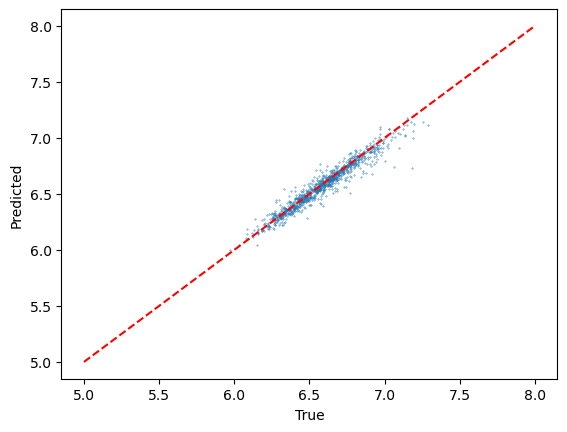

In [9]:
# Plot predictions
model.eval()
with torch.no_grad():
    for b,batch in enumerate(test_loader):
        features, labels = batch
        features = features.to(device)
        labels = labels.to(device)
        predictions = model(features)
        break
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()
    plt.scatter(labels, predictions, s=0.1)
    plt.plot([5, 8], [5, 8], "--", color='red')
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.show()